# Plot Sample KO counts from metaT

Given a table with sample x KO populated with normalized counts, make interesting plots

## Setup

In [53]:
import os 
import re
import glob
import umap
import numpy as np
import pandas as pd
from time import time
from scipy import stats
from collections import * 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
os.getcwd()

'/scratch/bgrodner/repo-armbrust-metat-search/other_docker_images/jupyter'

In [4]:
workdir = '/scratch/bgrodner/iron_ko_contigs'
os.chdir(workdir)


In [5]:
os.getcwd()

'/scratch/bgrodner/iron_ko_contigs'

In [6]:
os.listdir()

['config.yaml',
 'sc_run_snakemake.sh',
 'file_table.240107.kofam_filt.csv',
 'file_table.240109.kofam_filt.csv',
 'file_table_new.csv',
 '._file_table.240109.kofam_filt.csv',
 'file_table.test.csv',
 '._file_table.240107.kofam_filt.csv',
 'ko00001.json',
 '._file_table_new.csv',
 'file_table.240114.kofam_filt.csv',
 'metat_search_results',
 '._file_table.csv',
 'file_table.240113.kofam_filt.csv',
 'file_table.240107.kofam_unfilt.csv',
 '._file_table.240108.kofam_filt.csv',
 'kofam_filenames.txt',
 '.etetoolkit',
 'iron_contigs.txt',
 'iron_KOs.txt',
 'file_table.240108.kofam_filt.csv',
 'file_table.csv',
 '._file_table.240107.kofam_unfilt.csv',
 '._plt_KO_contig_counts.png',
 '._file_table.test.csv',
 '._file_table.240113.kofam_filt.csv',
 '._file_table.240114.kofam_filt.csv',
 '.snakemake']

## Load table and inspect

In [7]:
dir_combined = 'metat_search_results/dicts_iron_KO_contig/dicts_contig_count/tables_norm_count/combined'
fn_table_sample_ko_norm_counts = f'{dir_combined}/iron_KOs.txt-table_samples_KOs_norm_count.csv'

table = pd.read_csv(fn_table_sample_ko_norm_counts)
table.shape

(531, 404)

In [8]:
table.columns

Index(['fn_KO', 'fn_sample_counts', 'assembly', 'sample', 'ammendment',
       'timepoint', 'depth', 'size', 'rep', 'K02016',
       ...
       'K22336', 'K14712', 'K23910', 'K15762', 'K07238', 'K00205', 'K13857',
       'K08904', 'K00175', 'K23184'],
      dtype='object', length=404)

In [9]:
table[:3]

,fn_KO,fn_sample_counts,assembly,sample,ammendment,timepoint,depth,size,rep,K02016,...,K22336,K14712,K23910,K15762,K07238,K00205,K13857,K08904,K00175,K23184
0,NPac.D1PA.diel.bf100.id99.aa.best.kofam.incT30...,D1PA.S06C1_C_600.abundance.tsv,D1PA,S06C1,NaN,600,NaN,NaN,C,568201.706187,...,0.0,0.0,0.0,34350.0,2.936369e+06,0.0,0.0,89310.0,0.0,206841.37605
1,NPac.D1PA.diel.bf100.id99.aa.best.kofam.incT30...,D1PA.S15C1_C_200.abundance.tsv,D1PA,S15C1,NaN,200,NaN,NaN,C,417555.642714,...,1970.0,0.0,0.0,7880.0,2.861526e+06,1970.0,0.0,29550.0,1970.0,61070.00000
2,NPac.D1PA.diel.bf100.id99.aa.best.kofam.incT30...,D1PA.S34C1_C_2200.abundance.tsv,D1PA,S34C1,NaN,2200,NaN,NaN,C,528992.352820,...,0.0,0.0,0.0,5282.0,2.665839e+06,15846.0,0.0,23769.0,0.0,64476.52888


In [10]:
table.fn_KO.unique()

array(['NPac.D1PA.diel.bf100.id99.aa.best.kofam.incT30.csv.gz',
       'NPac.G1PA.bf100.id99.aa.best.Kofam.incT30.csv.gz',
       'G1NS_kofam2021_ALL.csv',
       'NPac.G2PA.bf100.id99.aa.best.Kofam.incT30.csv.gz',
       'G2NS_kofam2021_ALL.csv',
       'NPac.G3PA.UW.bf100.id99.aa.best.Kofam.incT30.csv.gz',
       'NPac.G3PA.diel.bf100.id99.aa.best.kofam.incT30.csv.gz',
       'G3NS_kofam2021_ALL.csv',
       'NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.csv.gz',
       'G5INC_mix_kofam2024_ALL.csv', 'G5INC_RR_kofam2024_ALL.csv'],
      dtype=object)

In [11]:
asss = table.assembly.unique()
asss

array(['D1PA', 'G1PA', 'G1NS', 'G2PA', 'G2NS', 'G3PA', 'G3PA.diel',
       'G3.UW.NS', 'G3.UW.PA', 'G5'], dtype=object)

In [12]:
for ass in asss:
    print(ass)
    print(table.loc[table.assembly == ass, 'sample'].unique())

D1PA
['S06C1' 'S15C1' 'S34C1' 'S16C1' 'S31C1' 'S14C1' 'S33C1' 'S22C1' 'S35C1'
 'S23C1' 'S08C1' 'S30C1' 'S19C1' 'S18C1' 'S29C1' 'S26C1' 'S24C1' 'S11C1'
 'S07C1' 'S17C1' 'S28C1' 'S21C1' 'S20C1' 'S32C1']
G1PA
['S08C1' 'S14C1' 'S06C1' 'S04C1' 'S02C1' 'S09C1' 'S12C1' 'S11C1' 'S10'
 'S13C1']
G1NS
['S13C1' 'S14C1' 'S04C1' 'S08C1' 'S12C1' 'S11C1' 'S06C1' 'S02C1' 'S09C1'
 'S10']
G2PA
['S16C1' 'S07C1' 'S06C1' 'S09C1' 'S11C1' 'S02C1' 'S15C1' 'S05C1' 'S17C1'
 'S18C1']
G2NS
['S16C1' 'S02C1' 'S17C1' 'S07C1' 'S06C1' 'S09C1' 'S18C1' 'S11C1' 'S15C1'
 'S05C1']
G3PA
['UW1' 'UW10' 'UW11' 'UW12' 'UW13' 'UW14' 'UW16' 'UW17' 'UW19' 'UW2'
 'UW20' 'UW21' 'UW22' 'UW23' 'UW24' 'UW25' 'UW26' 'UW27' 'UW28' 'UW29'
 'UW30' 'UW31' 'UW32' 'UW33' 'UW34' 'UW35' 'UW36' 'UW37' 'UW38' 'UW39'
 'UW4' 'UW40' 'UW41' 'UW42' 'UW43' 'UW44' 'UW45' 'UW46' 'UW47' 'UW48'
 'UW49' 'UW5' 'UW50' 'UW51' 'UW52' 'UW53' 'UW54' 'UW55' 'UW56' 'UW57'
 'UW59' 'UW60' 'UW62' 'UW63' 'UW64' 'UW66' 'UW67' 'UW7' 'UW8' 'UW9']
G3PA.diel
['S4C11' 'S4C13'

In [13]:
for ass in asss:
    print(ass)
    print(table.loc[table.assembly == ass, 'ammendment'].unique())

D1PA
[nan]
G1PA
[nan]
G1NS
[nan]
G2PA
[nan]
G2NS
[nan]
G3PA
[nan]
G3PA.diel
[nan]
G3.UW.NS
[nan]
G3.UW.PA
[nan]
G5
['DON' 'DOC' 'cont' 'DIN' 'NPSiFe' 'NPSi' 'Fe' 'NP']


In [14]:
for ass in asss:
    print(ass)
    print(table.loc[table.assembly == ass, 'timepoint'].unique())

D1PA
['600' '200' '2200' '1000' '1800' '1400']
G1PA
[nan]
G1NS
[nan]
G2PA
[nan]
G2NS
[nan]
G3PA
[nan]
G3PA.diel
[nan]
G3.UW.NS
[nan]
G3.UW.PA
['PM']
G5
['T2' 'T0' 'T24']


In [15]:
for ass in asss:
    print(ass)
    print(table.loc[table.assembly == ass, 'depth'].unique())

D1PA
[nan]
G1PA
[nan]
G1NS
[nan]
G2PA
['15m']
G2NS
['15m']
G3PA
[nan]
G3PA.diel
[nan]
G3.UW.NS
['1.7m' '3.7m' '2.7m']
G3.UW.PA
['1.7m' '2.7m']
G5
[nan]


In [16]:
for ass in asss:
    print(ass)
    print(table.loc[table.assembly == ass, 'size'].unique())

D1PA
[nan]
G1PA
['3um' '0.2um']
G1NS
['3um' '0.2um']
G2PA
['3um' '0.2um']
G2NS
['0.2um' '3um']
G3PA
[nan]
G3PA.diel
[nan]
G3.UW.NS
['3um' '0.2um']
G3.UW.PA
['0.2um' '3um']
G5
[nan]


In [17]:
for ass in asss:
    print(ass)
    print(table.loc[table.assembly == ass, 'rep'].unique())

D1PA
['C' 'B' 'A']
G1PA
['C' 'A' 'B']
G1NS
['A' 'B' 'C']
G2PA
['B' 'C' 'A']
G2NS
['C' 'A' 'B']
G3PA
[nan]
G3PA.diel
['A' 'B' 'C']
G3.UW.NS
['B' 'A' 'C']
G3.UW.PA
['AC' 'B' 'A' 'BC' 'C']
G5
['C' 'A' 'B']


## What is the distribution of the counts?

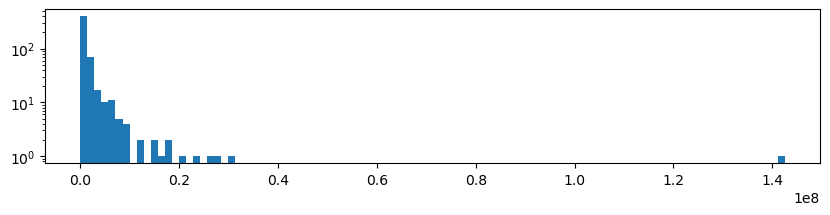

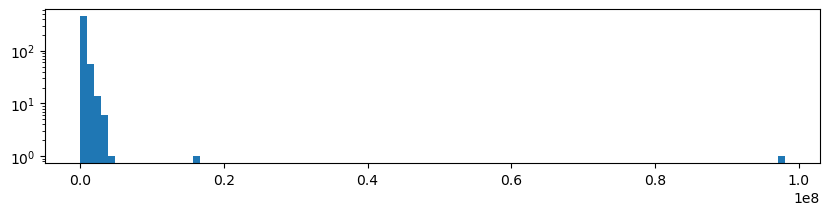

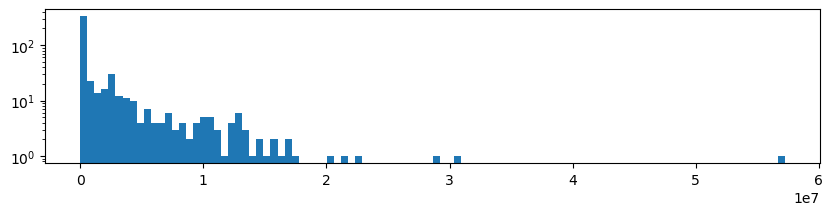

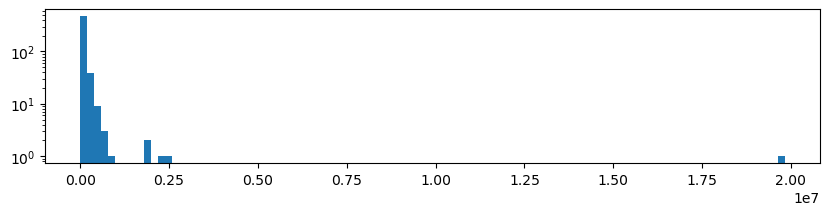

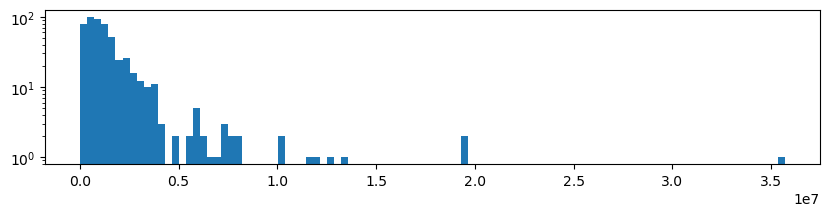

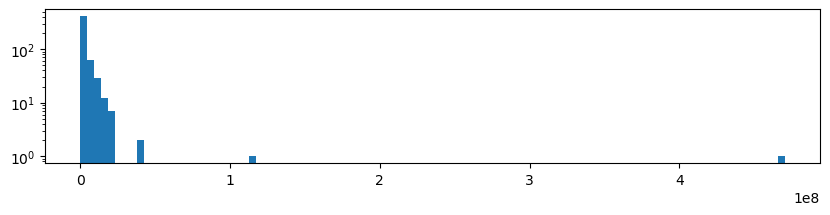

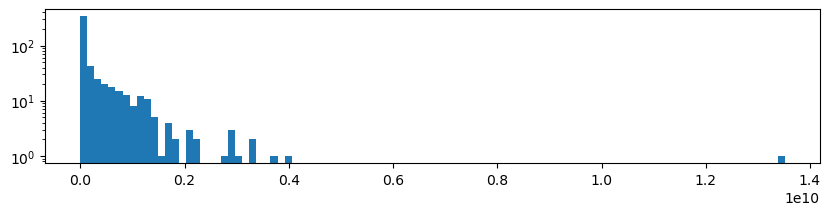

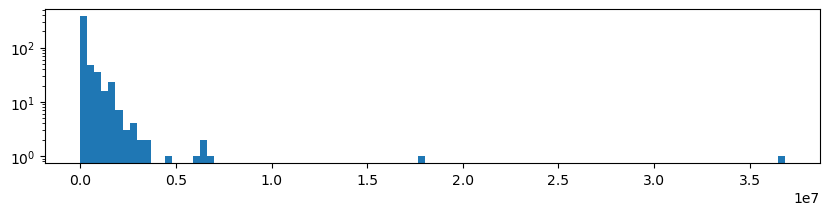

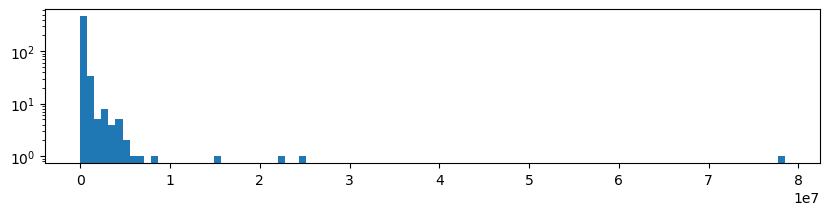

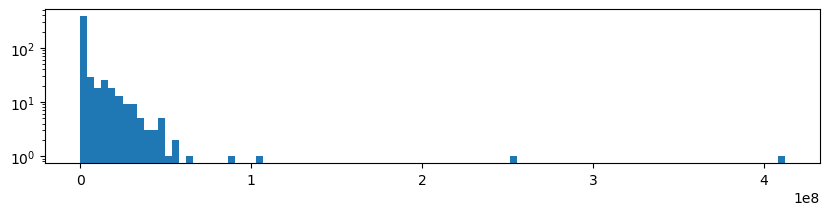

In [18]:
bins=100
size=(10,2)
for i in range(9,19):
    vals = table.iloc[:,i].values

    fig, ax = plt.subplots(figsize=(size))
    _ = ax.hist(vals, bins=bins)
    ax.set_yscale('log')
    plt.show()
    plt.close()

Is the outlier the same sample each time?

In [19]:
for i in range(9,19):
    row = table.iloc[:,i].argmax()
    print(table.iloc[row, :9])

fn_KO                   G2NS_kofam2021_ALL.csv
fn_sample_counts    G2NS.S06C1.15m.0_2um.B.tsv
assembly                                  G2NS
sample                                   S06C1
ammendment                                 NaN
timepoint                                  NaN
depth                                      15m
size                                     0.2um
rep                                          B
Name: 219, dtype: object
fn_KO                   G2NS_kofam2021_ALL.csv
fn_sample_counts    G2NS.S06C1.15m.0_2um.B.tsv
assembly                                  G2NS
sample                                   S06C1
ammendment                                 NaN
timepoint                                  NaN
depth                                      15m
size                                     0.2um
rep                                          B
Name: 219, dtype: object
fn_KO                   G2NS_kofam2021_ALL.csv
fn_sample_counts    G2NS.S06C1.15m.0_2um.B.tsv
assembly  

What is the norm factor?

In [20]:
dir_norm_factors = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/dicts_contig_count/norm_factors/G2NS_kofam2021_ALL.csv-iron_KOs.txt-norm_factors'
fn_norm_factor = f'{dir_norm_factors}/G2NS_kofam2021_ALL.csv-iron_KOs.txt-G2NS.S06C1.15m.0_2um.B.tsv-norm_factor.txt'
with open(fn_norm_factor, 'r') as f:
    print(f.read())

78106.9783783317


Other norm factors in the file

In [21]:
fns_norm_factor = glob.glob(dir_norm_factors + '/*')
for fn in fns_norm_factor:
    with open(fn, 'r') as f:
        print(f.read())

3189.50872643047
5764.0568028954
2312.57128801721
5504.09009285768
78106.9783783317
2353.90278051846
1390.87884332191
3233.56012021701
3147.94879013979
1533.5845792914
3688.13026101574
10498.9259088799
2047.45660485336
3550.88158497127
3066.16074692041
1704.24257147356
1842.42695262224
24398.1173217879
3810.04225983927
2079.85237255495
1480.00770094032
1826.01876833326
3114.82519599294
1407.46902134581
19134.0022961279
9921.90746106404
1899.4095223843
2935.16070285821
2430.05318967912
18308.0768533921
2000.87175009508
4780.46976770791
3879.38709081703
23731.4898635056
2185.71271441704
43983.3083453836
8749.24341092193
3587.92477941978
3926.82346124237
12081.1075806882
3383.27789006127
1613.27112260462
2324.46957579486
1577.27881900666
3944.15842247232
2128.22679294343
6251.00939978017
2136.62037274918
3139.66593861894
3707.89824346746
1317.72206215984
3745.91334289972
4264.84931277779
5879.90183515195
3063.83242347042
3870.44123475944
6297.54815437724
3906.33742999727
12224.7752932758


### Test for lognormality

(based on https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03892-w)

Shapiro-wilkes test for normality

Shapiro-wilkes test after log transform





In [22]:
nrm = []
lognrm = []
for i in range(9,table.shape[1]):
    vals = table.iloc[:,i].values
    vals_ln = np.log(vals)
    print(stats.shapiro(vals).pvalue, stats.shapiro(vals_ln).pvalue)


6.8409285444270125e-43 6.781792330393276e-06
1.2409002884711195e-44 1.0
1.0959108145967689e-35 1.0
1.244518471330088e-44 1.0
8.590123159383687e-37 6.155075422961643e-09
4.789400422561037e-44 1.0
1.342728050526779e-38 1.675941817130302e-21
2.3668672009423033e-42 1.0
7.546122459404497e-44 1.0
3.081102661262877e-41 1.0
7.425523657633765e-43 1.0
5.958643395414161e-38 1.0
1.7203916777392277e-34 0.7192578222747377
4.110754161187555e-45 1.0
2.331703205379579e-39 1.0
3.2258940113752117e-43 1.0
6.470621275961034e-45 1.0
2.601611390216789e-44 1.0
2.813680070745098e-45 1.0
5.435138449587383e-43 1.0
1.5676107132026987e-35 1.5893247314941854e-09
5.141646941544659e-40 1.0
5.0378413422414157e-45 1.0
1.0 1.0
2.256243526168299e-38 1.0
3.7893099138195855e-41 3.8425736591495345e-07
2.832568474858824e-44 1.0
2.7472572196490054e-44 1.0
2.68122380752458e-43 1.0
9.074962560121098e-44 7.4131299110573534e-06
2.857064653009768e-45 1.0
2.49698467367696e-41 3.4798918473546054e-07
4.299714184024922e-45 1.0
2.63480

/tmp/ipykernel_1074274/2811321816.py:5: RuntimeWarning: divide by zero encountered in log
  vals_ln = np.log(vals)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1967: RuntimeWarning: invalid value encountered in subtract
  y -= x[N//2]  # subtract the median (or a nearby value); see gh-15777
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


^ Basically not normal, sometimes maybe lognormal

Are there any KOs with no reads?

In [23]:
for i in range(9,table.shape[1]):
    if not table.iloc[:,i].sum():
        print(table.columns[i])

K26549
K26553
K26551
K26562
K14694
K26554
K27935
K08943
K26548
K26552
K26563


## Dimensional reduction

Functions

In [255]:
def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)


def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o'
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


def get_colors_from_stringlist(stringlist, order="", cmap_name="viridis"):
    if not order:
        order = list(set(stringlist))
    n_strings = len(order)
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / n_strings) for i in range(n_strings)]
    dict_str_col = {s: c for s, c in zip(order, colors)}
    return [dict_str_col[s] for s in stringlist], dict_str_col


def plot_legend(color_dict, figsize=(2, 4)):
    fig, ax = general_plot(dims=figsize)
    # Create legend handles manually
    legend_handles = []
    for value, color in color_dict.items():
        patch = mpatches.Patch(color=color, label=value)
        legend_handles.append(patch)

    # Add legend to the plot
    ax.legend(handles=legend_handles)
    return fig, ax


def taxon_legend(
    taxon_names,
    taxon_colors,
    label_color="k",
    taxon_counts=[],
    text_shift_vh=(6, 0.15),
    ft=20,
    dims=(6, 10),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    vals = np.repeat(10, len(taxon_names))
    y_pos = np.arange(len(taxon_names))
    ax.barh(y_pos, vals, align="center", color=taxon_colors)
    if len(taxon_counts) > 0:
        # Label the legend with counts
        for i, (v, c) in enumerate(zip(vals, taxon_counts)):
            ax.text(
                v - text_shift_vh[0],
                i + text_shift_vh[1],
                str(c),
                color="k",
                fontsize=ft,
            )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis
    ax.set_yticks(y_pos)
    ax.set_xticks([])
    ax.set_yticklabels(taxon_names)
    ax.invert_yaxis()
    return (fig, ax)


def marker_legend(
    names,
    markers,
    label_color="k",
    text_shift_hv=(0.5, 0),
    markersize=50,
    ft=20,
    dims=(3, 3),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    for i, (n, m) in enumerate(zip(names, markers)):
        ax.scatter(0, i, marker=m, c=label_color, s=markersize)
        # ax.text(
        #     0 - text_shift_hv[0],
        #     i + text_shift_hv[1],
        #     str(n),
        #     color=label_color,
        #     fontsize=ft,
        #     va="center",
        # )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, i + 1])

    ax.set_yticks(np.arange(i+1))
    ax.set_xticks([])
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    ax.invert_yaxis()
    return fig, ax

### Compare assemblies

In [448]:
reducer = umap.UMAP(n_neighbors=11, metric='cosine')

table_vals = table.iloc[:, 9:].values

embedding = reducer.fit_transform(table_vals)
embedding.shape

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(531, 2)

(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='UMAP 1', ylabel='UMAP 2'>)

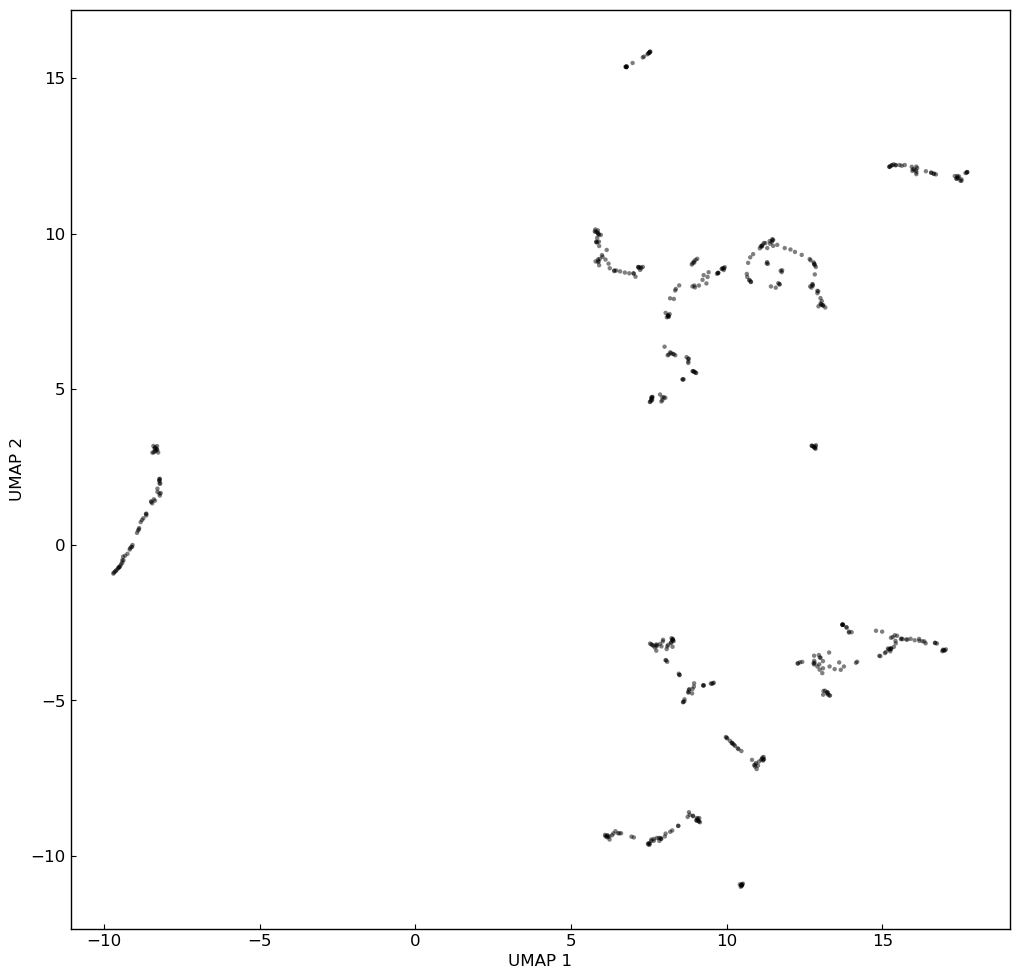

In [449]:
plot_umap(embedding=embedding)

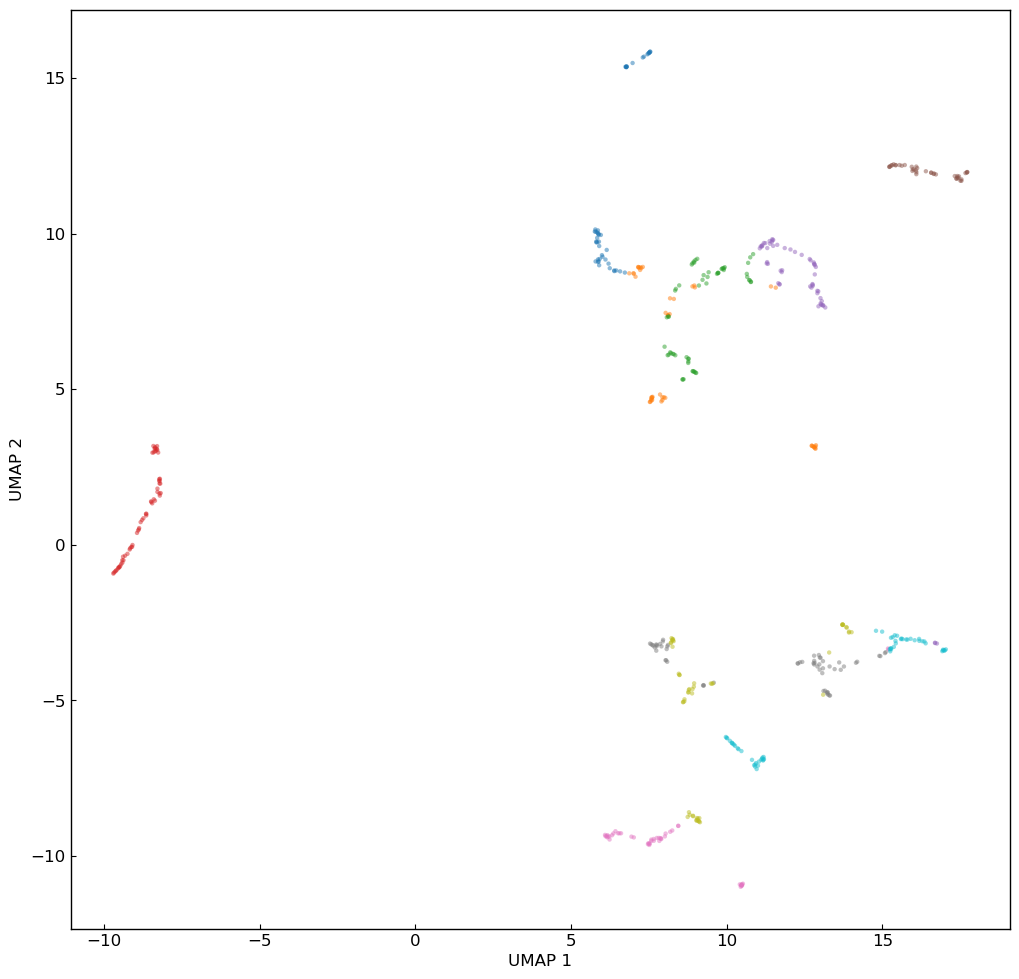

(<Figure size 100x200 with 1 Axes>, <Axes: ylabel='Assembly'>)

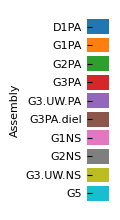

In [450]:



stringlist = table["assembly"].values
ass_order = [
    "D1PA",
    "G1PA",
    "G2PA",
    "G3PA",
    "G3.UW.PA",
    "G3PA.diel",
    "G1NS",
    "G2NS",
    "G3.UW.NS",
    "G5",
]
c, dict_ass_col = get_colors_from_stringlist(
    stringlist=stringlist,
    order=ass_order,
    cmap_name='tab10'
)

plot_umap(
    embedding=embedding, 
    colors=c
)
plt.show()
plt.close()

colors = [dict_ass_col[n] for n in ass_order]
taxon_legend(ass_order, colors, dims=(1,2), ylabel='Assembly', ft=8)

### Compare timepoints in D1 Diel

In [451]:
table_vals = table.iloc[:, 9:][table.assembly == 'D1PA'].values

embedding = reducer.fit_transform(table_vals)
embedding.shape

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(48, 2)

(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='UMAP 1', ylabel='UMAP 2'>)

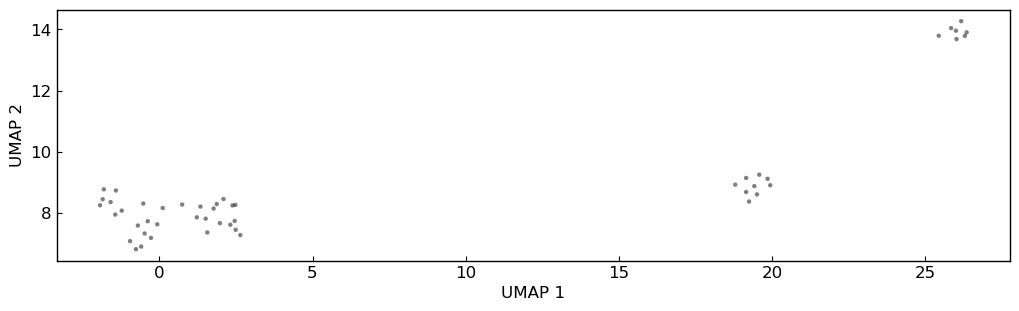

In [452]:

plot_umap(embedding=embedding)

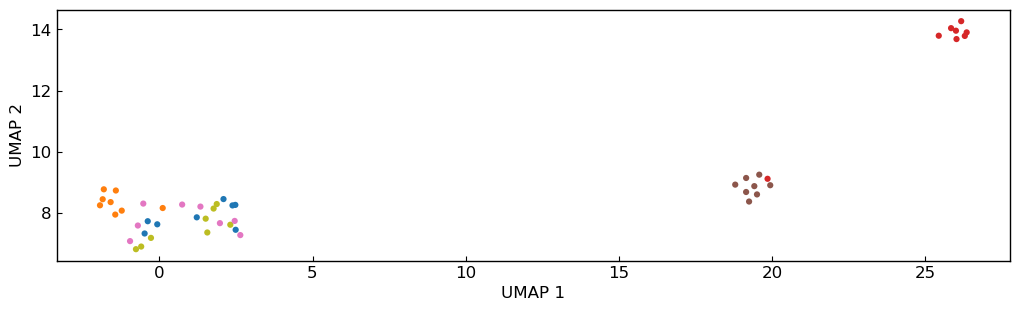

(<Figure size 75x100 with 1 Axes>, <Axes: ylabel='Time'>)

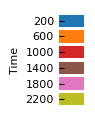

In [453]:
stringlist = table.loc[table.assembly == 'D1PA', "timepoint"].values
order = [
    '200',
    '600',
    '1000',
    '1400',
    '1800',
    '2200'
]
c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist,
    order=order,
    cmap_name='tab10'
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=20
)
plt.show()
plt.close()

colors = [dict_time_col[t] for t in order]
taxon_legend(order, colors, dims=(0.75, 1), ylabel="Time", ft=8)

### Compare timepoints in G3 Diel

(40, 2)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='UMAP 1', ylabel='UMAP 2'>)

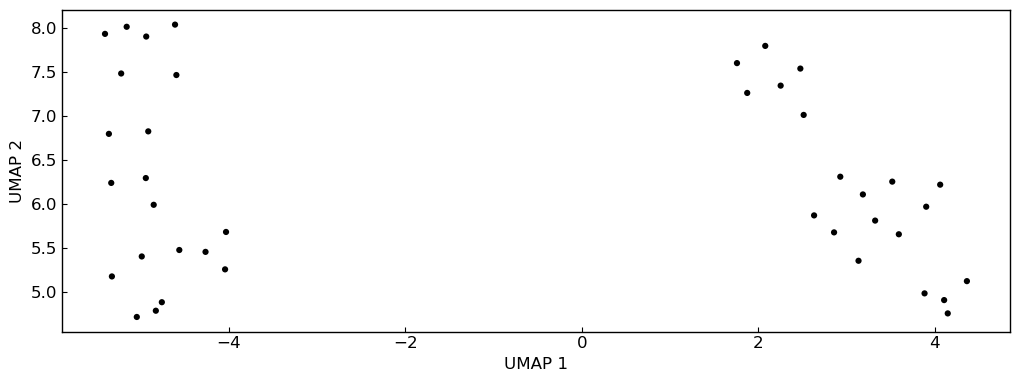

In [454]:
bool_ass = table.assembly == "G3PA.diel"

table_vals_sub = table.iloc[:, 9:][bool_ass].values

embedding = reducer.fit_transform(table_vals_sub)
print(embedding.shape)
plot_umap(embedding=embedding, alpha=1, markersize=20)

Get timepoints

In [455]:
samples = table.loc[bool_ass, 'sample'].values
samples[:10]

array(['S4C11', 'S4C11', 'S4C11', 'S4C13', 'S4C13', 'S4C15', 'S4C15',
       'S4C15', 'S4C16', 'S4C16'], dtype=object)

Load metadata table

In [456]:
dir_diel = '../repo-armbrust-metat/gradients3/g3_diel_pa_metat'
fn_G3PA_diel_metadata = f'{dir_diel}/sample_metadata.csv'
G3PA_diel_metadata = pd.read_csv(fn_G3PA_diel_metadata)
G3PA_diel_metadata.shape, G3PA_diel_metadata[:3]

((44, 14),
             SampleID  Cruise  Station  Cast  Filter Replicate  Depth  \
 0  G3PA.diel.S4C11.A  km1906        4    11     0.2         A     15   
 1  G3PA.diel.S4C11.B  km1906        4    11     0.2         B     15   
 2  G3PA.diel.S4C11.C  km1906        4    11     0.2         C     15   
 
         Datetime  Latitude  Longitude  SequencingID   Alias1 Alias2 Notes  
 0  4/16/19 17:42     41.67    -158.03        390043  S4C11 A    D42  diel  
 1  4/16/19 17:42     41.67    -158.03        390030  S4C11 B    D29  diel  
 2  4/16/19 17:42     41.67    -158.03        390016  S4C11 C    D11  diel  )

Build sample timepoint dict

In [457]:
dict_tp_sample = {}
for i, row in G3PA_diel_metadata.iterrows():
    sample = row.Alias1.split(' ')[0]
    dict_tp_sample[row.Datetime] = sample


Sort datetime

In [458]:
df_dt = G3PA_diel_metadata.Datetime.to_frame()
df_dt["day"] = [
    dt.split(' ')[0] for dt in df_dt.Datetime.values
]
df_dt["hour"] = [
    int(re.search(r"(?<=\s)\d+(?=\:)", dt)[0]) for dt in df_dt.Datetime.values
]
df_dt = df_dt.sort_values(by=['day','hour'], ascending=True)
datetime_sort = df_dt.Datetime.unique()
datetime_sort

array(['4/16/19 3:16', '4/16/19 6:10', '4/16/19 9:36', '4/16/19 13:39',
       '4/16/19 17:42', '4/16/19 23:07', '4/17/19 2:58', '4/17/19 5:58',
       '4/17/19 9:50', '4/17/19 13:37', '4/17/19 17:25', '4/17/19 21:20',
       '4/18/19 1:27', '4/18/19 5:22', '4/18/19 8:14', '4/18/19 12:06'],
      dtype=object)

Color umap by timepoint

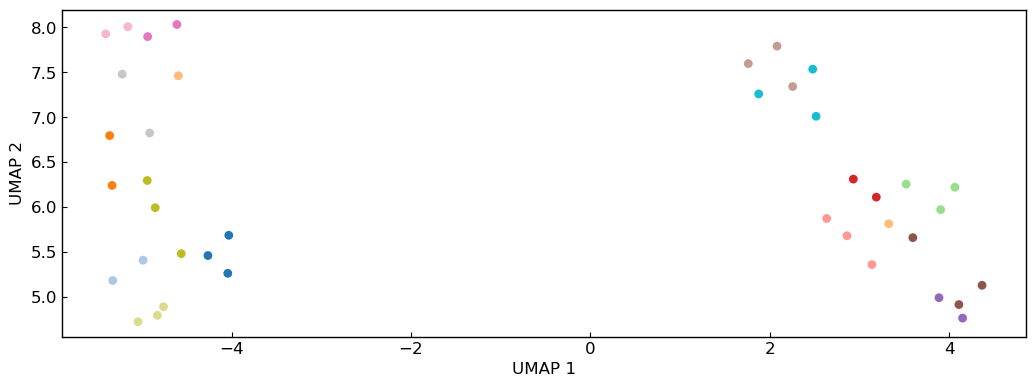

(<Figure size 150x500 with 1 Axes>, <Axes: ylabel='Time'>)

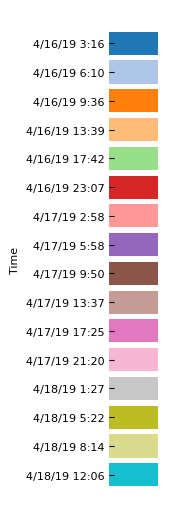

In [459]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="tab20"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40
)
plt.show()
plt.close()

names = datetime_sort
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 5), ylabel="Time", ft=8)

### Compare Lattitudes in G1PA

(47, 2)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='UMAP 1', ylabel='UMAP 2'>)

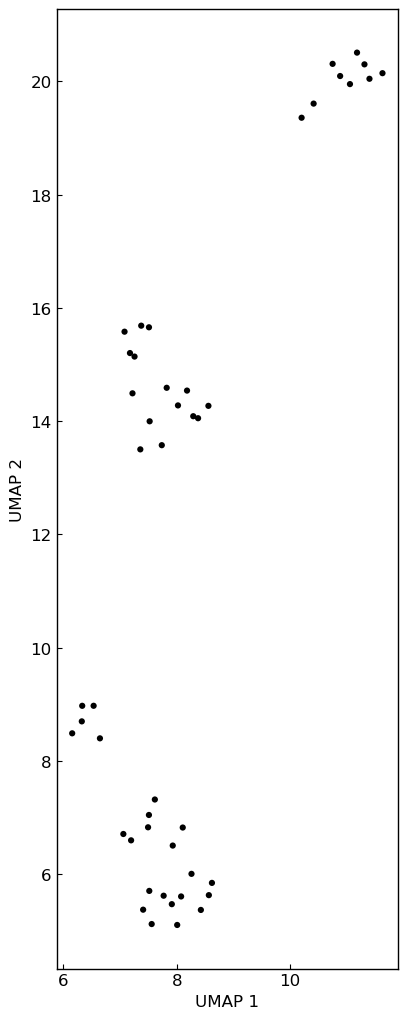

In [460]:
bool_ass = table.assembly == "G1PA"

table_vals_sub = table.iloc[:, 9:][bool_ass].values

embedding = reducer.fit_transform(table_vals_sub)
print(embedding.shape)
plot_umap(embedding=embedding, alpha=1, markersize=20)

Get latitudes

In [461]:
samples = table.loc[bool_ass, 'sample'].values
np.unique(samples)

array(['S02C1', 'S04C1', 'S06C1', 'S08C1', 'S09C1', 'S10', 'S11C1',
       'S12C1', 'S13C1', 'S14C1'], dtype=object)

Load metadata table

In [462]:
dir_diel = '../repo-armbrust-metat/gradients1/g1_station_pa_metat'
fn_G3PA_diel_metadata = f'{dir_diel}/sample_metadata.csv'

G3PA_diel_metadata = pd.read_csv(fn_G3PA_diel_metadata)
G3PA_diel_metadata.shape, G3PA_diel_metadata[:3]

((52, 14),
        SampleID   Cruise  Station  Cast  Filter Replicate  Depth  \
 0  S02C1_0_2umA  kok1606        2   1.0     0.2         A     15   
 1  S02C1_0_2umB  kok1606        2   1.0     0.2         B     15   
 2  S02C1_0_2umC  kok1606        2   1.0     0.2         C     15   
 
         Datetime   Latitude   Longitude  SequencingID       Alias1  \
 0  4/20/16 15:11  23.495833  157.994333      175911.0  S2C1_0.2umA   
 1  4/20/16 15:11  23.495833  157.994333      175890.0  S2C1_0.2umB   
 2  4/20/16 15:11  23.495833  157.994333      175915.0  S2C1_0.2umC   
 
          Alias2 Notes  
 0  S02C1_0.2umA   NaN  
 1  S02C1_0.2umB   NaN  
 2  S02C1_0.2umC   NaN  )

Build sample latitude dict

In [463]:
row.Alias2

'D37'

In [464]:
dict_tp_sample = {}
for i, row in G3PA_diel_metadata.iterrows():
    alias = row.Alias2
    if isinstance(alias, str):
        sample = alias.split('_')[0]
        dict_tp_sample[row.Latitude] = sample
dict_tp_sample

{23.49583333: 'S02C1',
 28.14316667: 'S04C1',
 32.5835: 'S06C1',
 37.30116667: 'S08C1',
 36.57: 'S09C1',
 35.46266667: 'S10',
 36.569: 'S11C1',
 33.09116667: 'S12C1',
 29.69983333: 'S13C1',
 26.2825: 'S14C1'}

Sort latitudes

In [465]:
datetime_sort = sorted(list(dict_tp_sample.keys()))
datetime_sort

[23.49583333,
 26.2825,
 28.14316667,
 29.69983333,
 32.5835,
 33.09116667,
 35.46266667,
 36.569,
 36.57,
 37.30116667]

Color umap by latitude

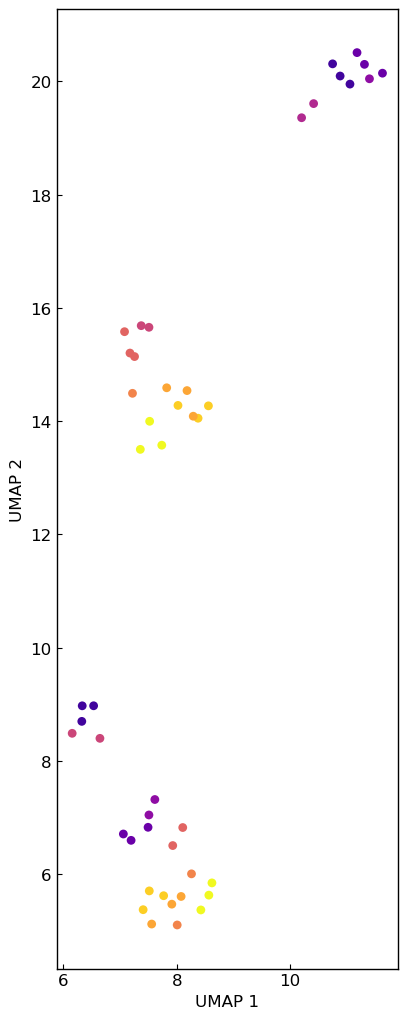

(<Figure size 150x300 with 1 Axes>, <Axes: ylabel='Latitude'>)

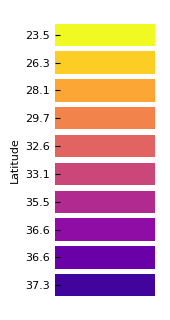

In [466]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

#### Separate by size fraction

In [467]:
sizes = table.loc[bool_ass, 'size'].unique()
sizes

array(['3um', '0.2um'], dtype=object)

In [468]:
markers = ['o','x']
dict_size_marker = dict(zip(sizes, markers))

sizes_all = table.loc[bool_ass, 'size'].values

markerstyle = [dict_size_marker[s] for s in sizes_all]

/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


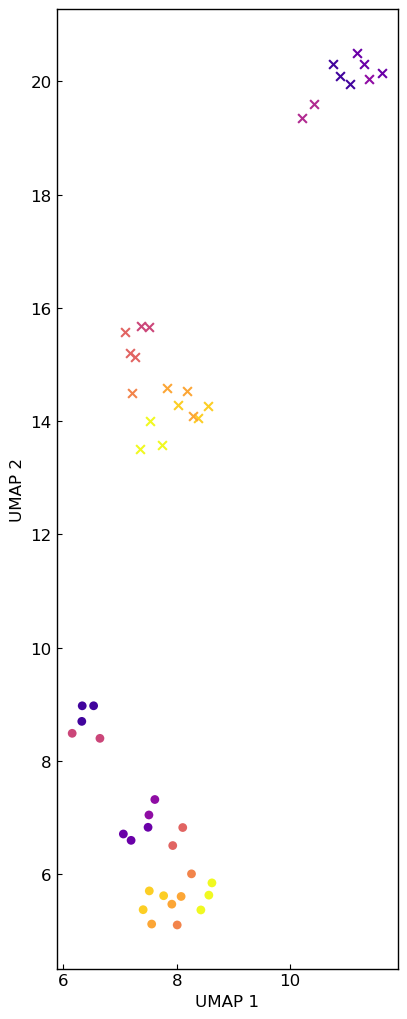

(<Figure size 100x100 with 1 Axes>, <Axes: ylabel='Size Fraction'>)

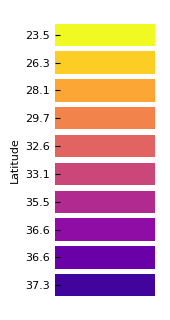

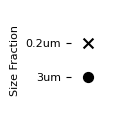

In [469]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40,
    markerstyle=markerstyle
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

marker_legend(
    sizes,
    markers,
    ylabel="Size Fraction",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)

### Compare Lattitudes in G1NS

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(48, 2)


(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='UMAP 1', ylabel='UMAP 2'>)

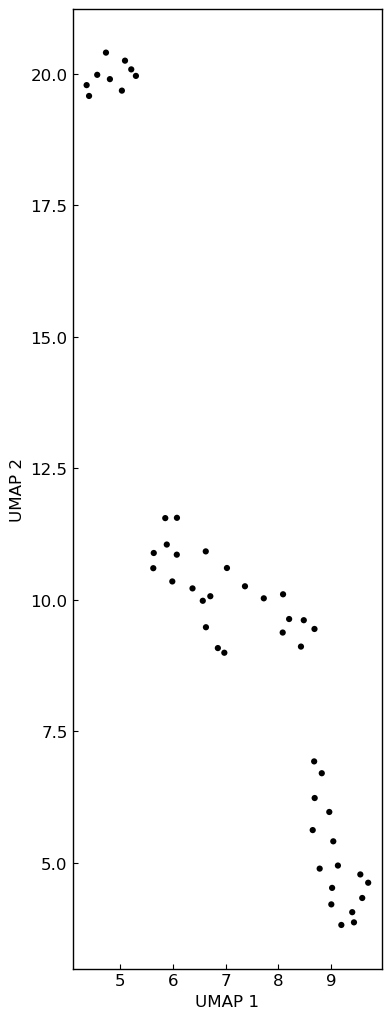

In [470]:
bool_ass = table.assembly == "G1NS"

table_vals_sub = table.iloc[:, 9:][bool_ass].values

embedding = reducer.fit_transform(table_vals_sub)
print(embedding.shape)
plot_umap(embedding=embedding, alpha=1, markersize=20)

Get latitudes

In [471]:
samples = table.loc[bool_ass, 'sample'].values
np.unique(samples)

array(['S02C1', 'S04C1', 'S06C1', 'S08C1', 'S09C1', 'S10', 'S11C1',
       'S12C1', 'S13C1', 'S14C1'], dtype=object)

Load metadata table

In [472]:
dir_diel = '../repo-armbrust-metat/gradients1/g1_station_ns_metat'
fn_G3PA_diel_metadata = f'{dir_diel}/sample_metadata.csv'

G3PA_diel_metadata = pd.read_csv(fn_G3PA_diel_metadata)
G3PA_diel_metadata.shape, G3PA_diel_metadata[:3]

((48, 14),
                        SampleID   Cruise  Station  Cast  Filter Replicate  \
 0  G1.SURF.NS.S02C1.15m.0_2um.A  kok1606        2     1     0.2         A   
 1  G1.SURF.NS.S02C1.15m.0_2um.B  kok1606        2     1     0.2         B   
 2  G1.SURF.NS.S02C1.15m.0_2um.C  kok1606        2     1     0.2         C   
 
    Depth       Datetime   Latitude   Longitude  SequencingID       Alias1  \
 0     15  4/20/16 15:11  23.495833 -157.994333        212560  S2C1 0.2umA   
 1     15  4/20/16 15:11  23.495833 -157.994333        212539  S2C1 0.2umB   
 2     15  4/20/16 15:11  23.495833 -157.994333        212564  S2C1 0.2umC   
 
          Alias2 Notes  
 0  S02C1_0_2umA  none  
 1  S02C1_0_2umB  none  
 2  S02C1_0_2umC  none  )

Build sample latitude dict

In [473]:
row.Alias2

'S14C1_3umC'

In [474]:
dict_tp_sample = {}
for i, row in G3PA_diel_metadata.iterrows():
    alias = row.Alias2
    if isinstance(alias, str):
        sample = alias.split('_')[0]
        dict_tp_sample[row.Latitude] = sample
dict_tp_sample

{23.49583333: 'S02C1',
 28.14316667: 'S04C1',
 32.5835: 'S06C1',
 37.30116667: 'S08C1',
 36.57: 'S09C1',
 35.46266667: 'S10',
 36.569: 'S11C1',
 33.09116667: 'S12C1',
 29.69983333: 'S13C1',
 26.2825: 'S14C1'}

Sort latitudes

In [475]:
datetime_sort = sorted(list(dict_tp_sample.keys()))
datetime_sort

[23.49583333,
 26.2825,
 28.14316667,
 29.69983333,
 32.5835,
 33.09116667,
 35.46266667,
 36.569,
 36.57,
 37.30116667]

Color umap by latitude

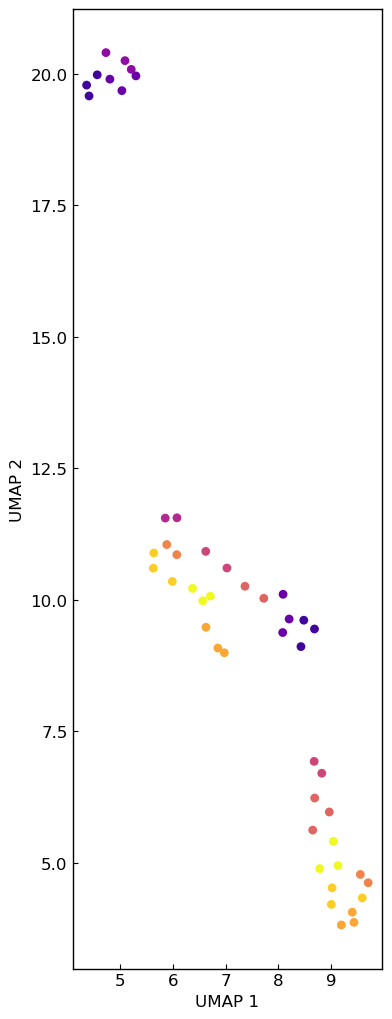

(<Figure size 150x300 with 1 Axes>, <Axes: ylabel='Latitude'>)

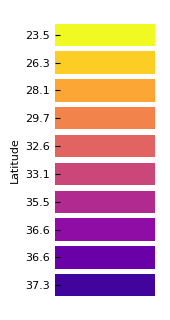

In [476]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

#### Separate by size fraction

In [477]:
sizes = table.loc[bool_ass, 'size'].unique()
sizes

array(['3um', '0.2um'], dtype=object)

In [478]:
markers = ['o','x']
dict_size_marker = dict(zip(sizes, markers))

sizes_all = table.loc[bool_ass, 'size'].values

markerstyle = [dict_size_marker[s] for s in sizes_all]

/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


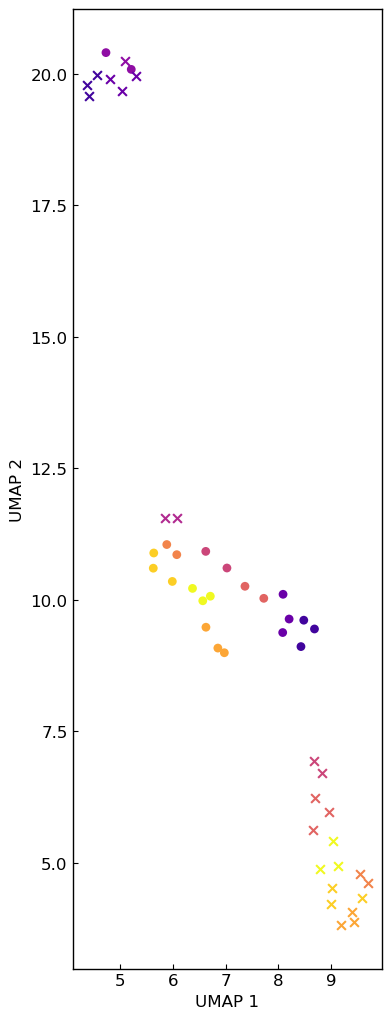

(<Figure size 100x100 with 1 Axes>, <Axes: ylabel='Size Fraction'>)

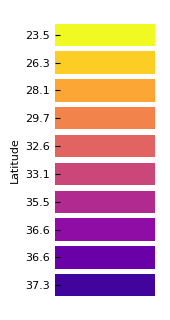

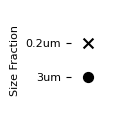

In [479]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40,
    markerstyle=markerstyle
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

marker_legend(
    sizes,
    markers,
    ylabel="Size Fraction",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)

### Compare Lattitudes in G2PA

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(59, 2)


(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='UMAP 1', ylabel='UMAP 2'>)

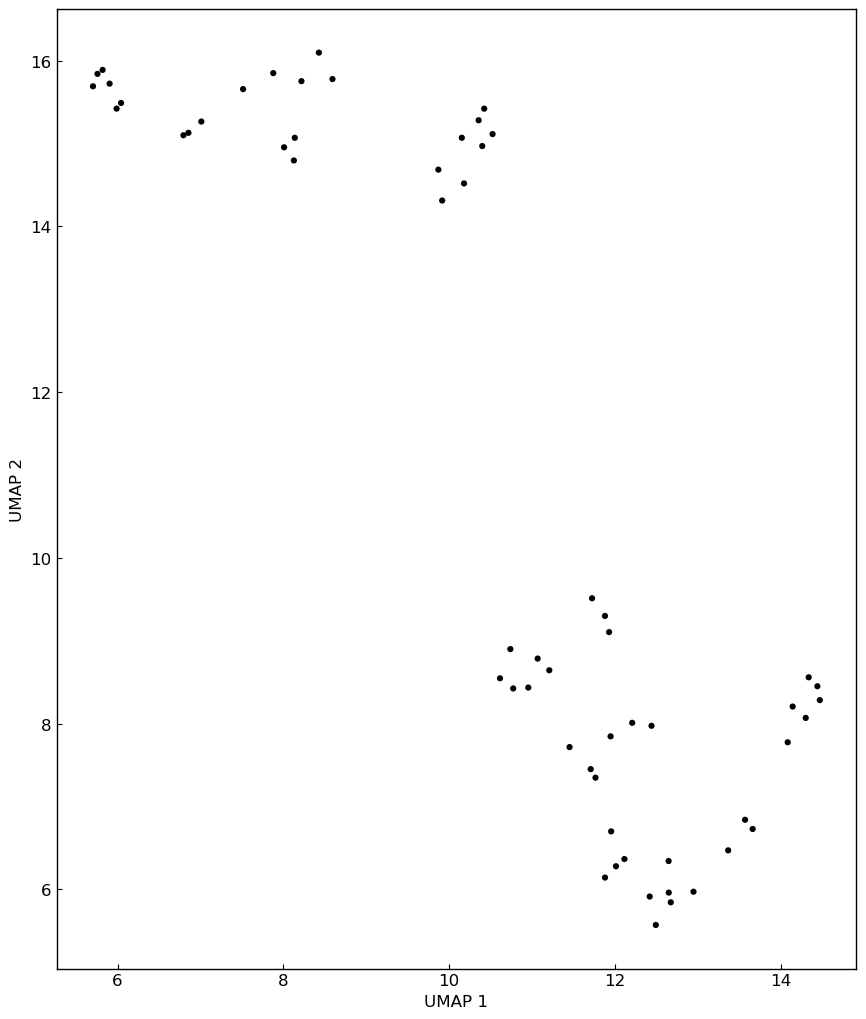

In [480]:
bool_ass = table.assembly == "G2PA"

table_vals_sub = table.iloc[:, 9:][bool_ass].values

embedding = reducer.fit_transform(table_vals_sub)
print(embedding.shape)
plot_umap(embedding=embedding, alpha=1, markersize=20)

Get latitudes

In [481]:
samples = table.loc[bool_ass, 'sample'].values
np.unique(samples)

array(['S02C1', 'S05C1', 'S06C1', 'S07C1', 'S09C1', 'S11C1', 'S15C1',
       'S16C1', 'S17C1', 'S18C1'], dtype=object)

Load metadata table

In [482]:
dir_diel = '../repo-armbrust-metat/gradients2/g2_station_pa_metat'
fn_G3PA_diel_metadata = f'{dir_diel}/sample_metadata.csv'

G3PA_diel_metadata = pd.read_csv(fn_G3PA_diel_metadata)
G3PA_diel_metadata.shape, G3PA_diel_metadata[:3]

((60, 20),
             SampleID   Cruise  Station  Cast  Filter Replicate   Latitude  \
 0  S02C1.15m.0_2um.A  mgl1704      2.0   1.0     0.2         A  25.768333   
 1  S02C1.15m.0_2um.B  mgl1704      2.0   1.0     0.2         B  25.768333   
 2  S02C1.15m.0_2um.C  mgl1704      2.0   1.0     0.2         C  25.768333   
 
     Longitude  SequencingID          Alias1                  Alias2 Notes  \
 0 -158.014167        301465  S2C1Surf0.2umA  G2PA.S02C1.15m.0_2um.A   NaN   
 1 -158.014167        301435  S2C1Surf0.2umB  G2PA.S02C1.15m.0_2um.B   NaN   
 2 -158.014167        301441  S2C1Surf0.2umC  G2PA.S02C1.15m.0_2um.C   NaN   
 
    Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  Unnamed: 16  \
 0          NaN          NaN          NaN          NaN          NaN   
 1          NaN          NaN          NaN          NaN          NaN   
 2          NaN          NaN          NaN          NaN          NaN   
 
    Unnamed: 17  Unnamed: 18  Unnamed: 19  
 0          NaN          NaN   

Build sample latitude dict

In [483]:
dict_tp_sample = {}
for i, row in G3PA_diel_metadata.iterrows():
    alias = row.Alias2
    if isinstance(alias, str):
        if not np.isnan(row.Latitude):
            sample = alias.split('.')[1]
            dict_tp_sample[row.Latitude] = sample
dict_tp_sample

{25.76833333: 'S02C1',
 36.062: 'S05C1',
 39.76333333: 'S06C1',
 41.41666667: 'S07C1',
 37.99983333: 'S09C1',
 36.99983333: 'S11C1',
 34.00016667: 'S15C1',
 32.92883333: 'S16C1',
 32.00016667: 'S17C1',
 29.582: 'S18C1'}

Sort latitudes

In [484]:
datetime_sort = sorted(list(dict_tp_sample.keys()))
datetime_sort

[25.76833333,
 29.582,
 32.00016667,
 32.92883333,
 34.00016667,
 36.062,
 36.99983333,
 37.99983333,
 39.76333333,
 41.41666667]

Color umap by latitude

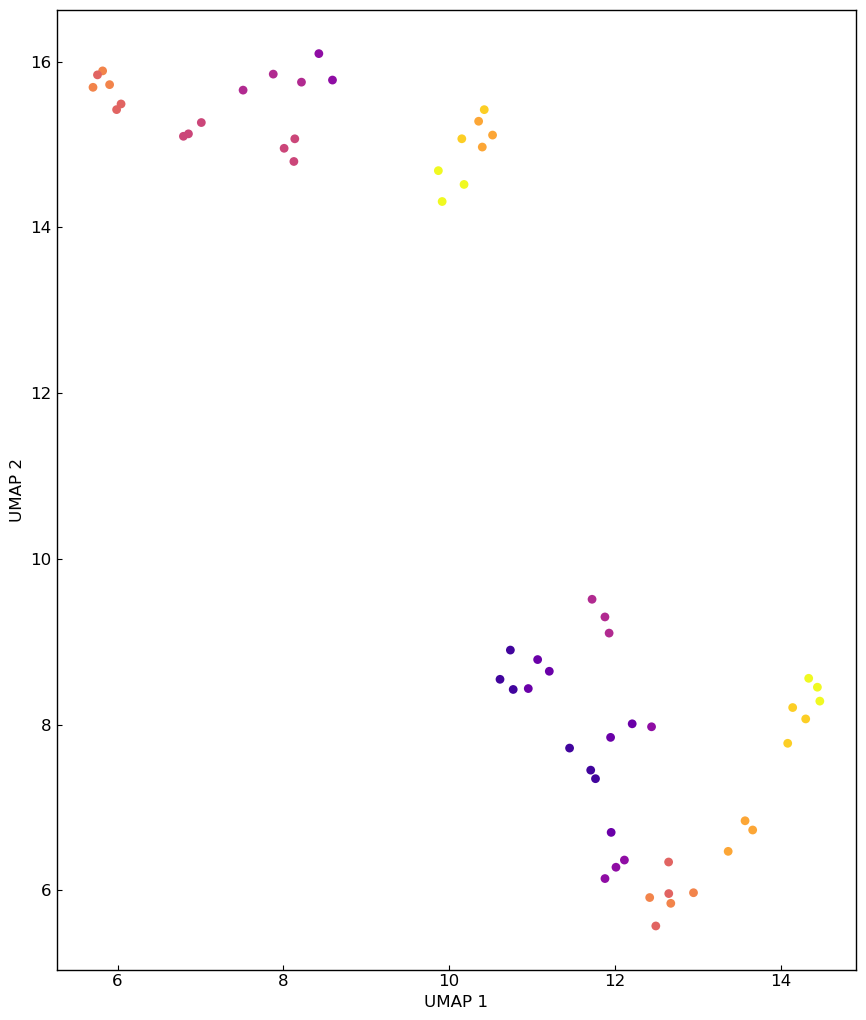

(<Figure size 150x300 with 1 Axes>, <Axes: ylabel='Latitude'>)

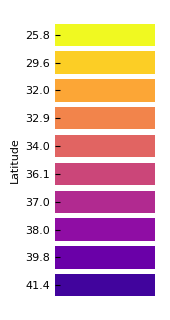

In [485]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

#### Separate by size fraction

In [486]:
sizes = table.loc[bool_ass, 'size'].unique()
sizes

array(['3um', '0.2um'], dtype=object)

In [487]:
markers = ['o','x']
dict_size_marker = dict(zip(sizes, markers))

sizes_all = table.loc[bool_ass, 'size'].values

markerstyle = [dict_size_marker[s] for s in sizes_all]

/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


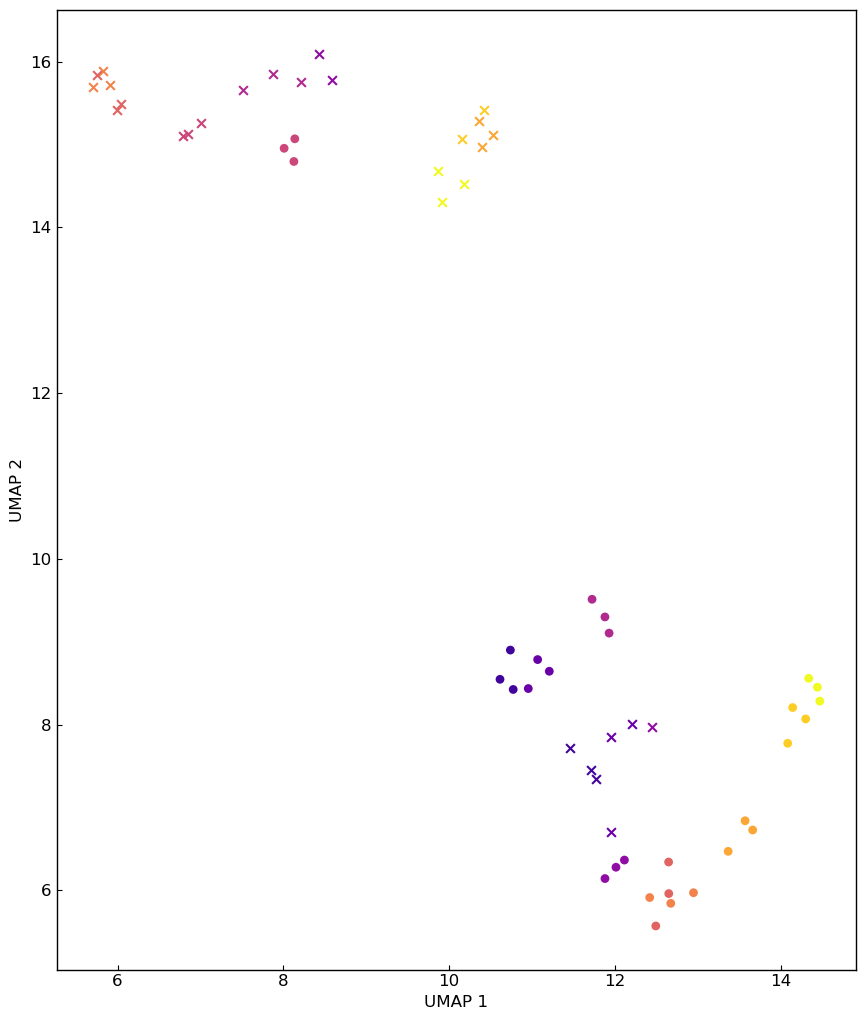

(<Figure size 100x100 with 1 Axes>, <Axes: ylabel='Size Fraction'>)

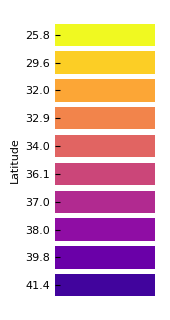

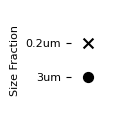

In [488]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40,
    markerstyle=markerstyle
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

marker_legend(
    sizes,
    markers,
    ylabel="Size Fraction",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)

### Compare Lattitudes in G2NS

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(60, 2)


(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='UMAP 1', ylabel='UMAP 2'>)

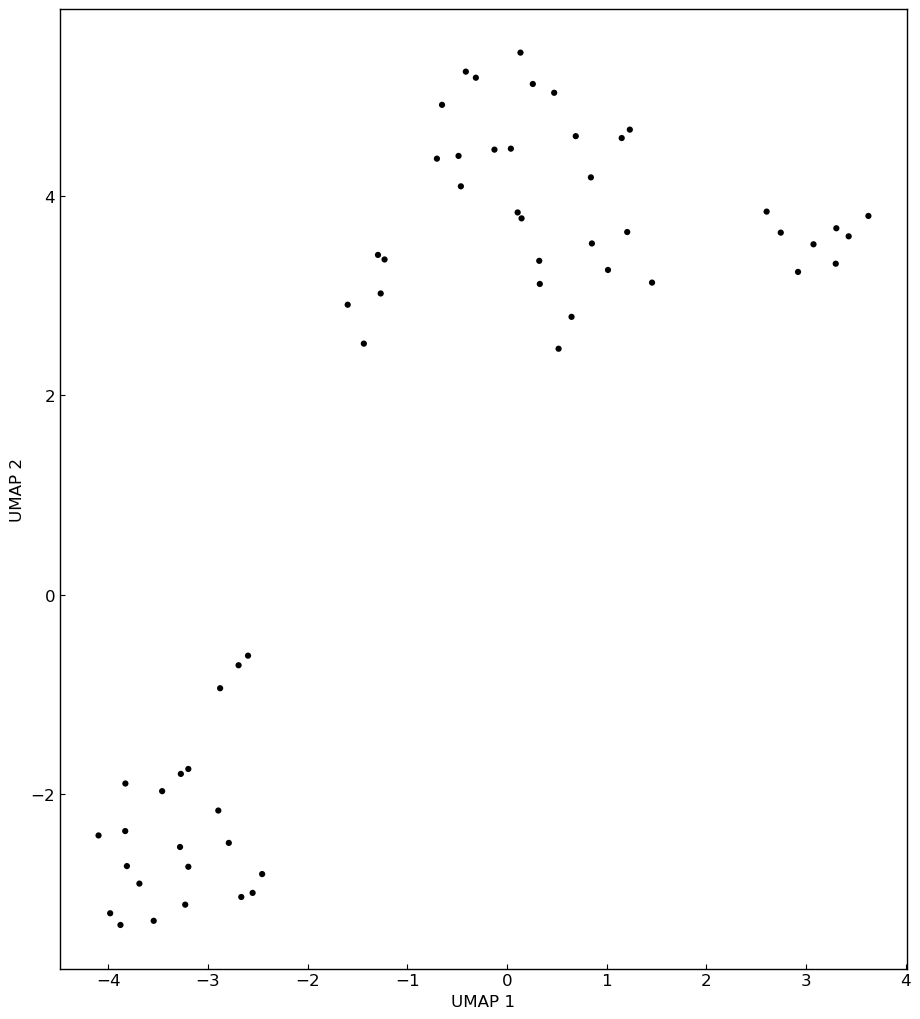

In [489]:
bool_ass = table.assembly == "G2NS"

table_vals_sub = table.iloc[:, 9:][bool_ass].values

embedding = reducer.fit_transform(table_vals_sub)
print(embedding.shape)
plot_umap(embedding=embedding, alpha=1, markersize=20)

Get latitudes

In [490]:
samples = table.loc[bool_ass, 'sample'].values
np.unique(samples)

array(['S02C1', 'S05C1', 'S06C1', 'S07C1', 'S09C1', 'S11C1', 'S15C1',
       'S16C1', 'S17C1', 'S18C1'], dtype=object)

Load metadata table

In [491]:
dir_diel = '../repo-armbrust-metat/gradients2/g2_station_ns_metat'
fn_G3PA_diel_metadata = f'{dir_diel}/sample_metadata.csv'

G3PA_diel_metadata = pd.read_csv(fn_G3PA_diel_metadata)
G3PA_diel_metadata.shape, G3PA_diel_metadata[:3]

((60, 14),
                        SampleID   Cruise  Station  Cast  Filter Replicate  \
 0  G2.SURF.NS.S02C1.15m.0_2um.A  mgl1704        2     1     0.2         A   
 1  G2.SURF.NS.S02C1.15m.0_2um.B  mgl1704        2     1     0.2         B   
 2  G2.SURF.NS.S02C1.15m.0_2um.C  mgl1704        2     1     0.2         C   
 
    Depth       Datetime   Latitude   Longitude  SequencingID          Alias1  \
 0     15  5/29/17 14:26  25.768333 -158.014167        301405  S2C1Surf0.2umA   
 1     15  5/29/17 14:26  25.768333 -158.014167        301375  S2C1Surf0.2umB   
 2     15  5/29/17 14:26  25.768333 -158.014167        301381  S2C1Surf0.2umC   
 
               Alias2 Notes  
 0  S02C1.15m.0_2um.A  none  
 1  S02C1.15m.0_2um.B  none  
 2  S02C1.15m.0_2um.C  none  )

Build sample latitude dict

In [492]:
dict_tp_sample = {}
for i, row in G3PA_diel_metadata.iterrows():
    alias = row.Alias2
    if isinstance(alias, str):
        if not np.isnan(row.Latitude):
            sample = alias.split('.')[0]
            dict_tp_sample[row.Latitude] = sample
dict_tp_sample

{25.76833333: 'S02C1',
 36.062: 'S05C1',
 39.76333333: 'S06C1',
 41.41666667: 'S07C1',
 37.99983333: 'S09C1',
 36.99983333: 'S11C1',
 34.00016667: 'S15C1',
 32.92883333: 'S16C1',
 32.00016667: 'S17C1',
 29.582: 'S18C1'}

Sort latitudes

In [493]:
datetime_sort = sorted(list(dict_tp_sample.keys()))
datetime_sort

[25.76833333,
 29.582,
 32.00016667,
 32.92883333,
 34.00016667,
 36.062,
 36.99983333,
 37.99983333,
 39.76333333,
 41.41666667]

Color umap by latitude

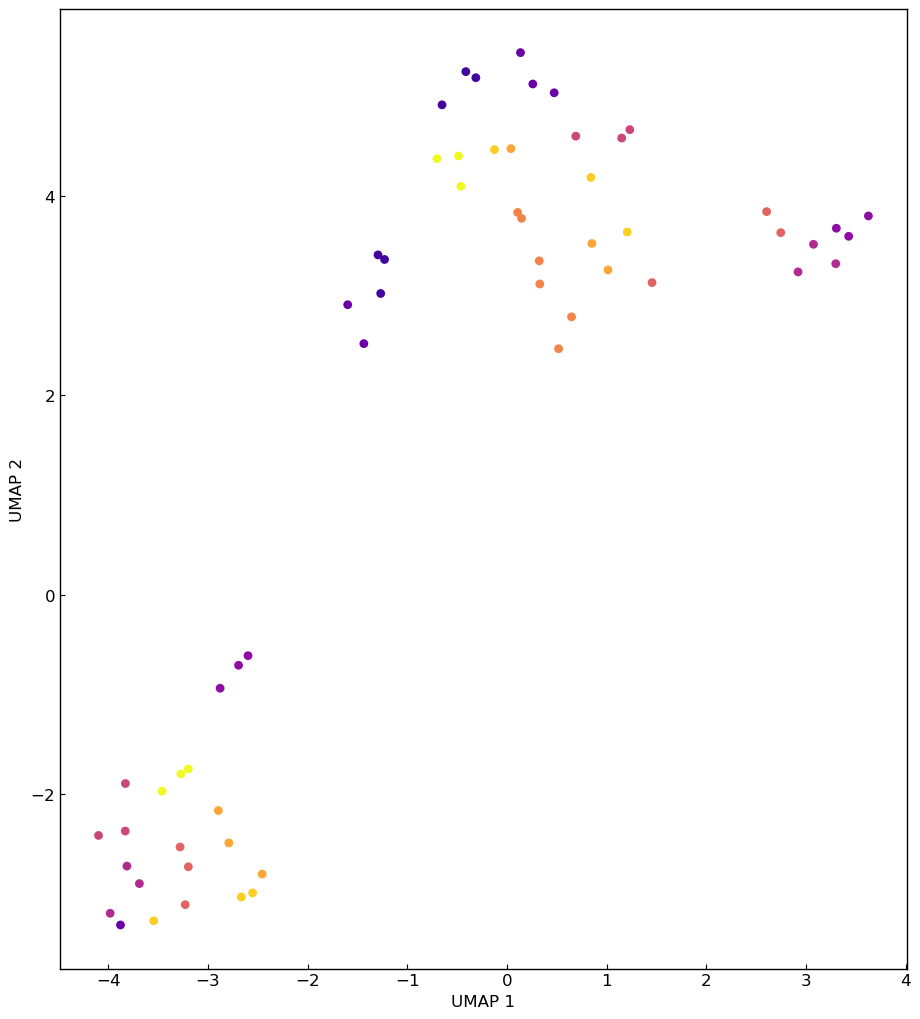

(<Figure size 150x300 with 1 Axes>, <Axes: ylabel='Latitude'>)

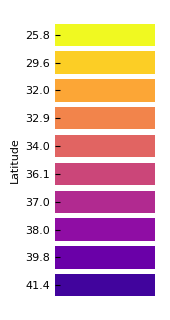

In [494]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

#### Separate by size fraction

In [495]:
sizes = table.loc[bool_ass, 'size'].unique()
sizes

array(['0.2um', '3um'], dtype=object)

In [496]:
markers = ['o','x']
dict_size_marker = dict(zip(sizes, markers))

sizes_all = table.loc[bool_ass, 'size'].values

markerstyle = [dict_size_marker[s] for s in sizes_all]

/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


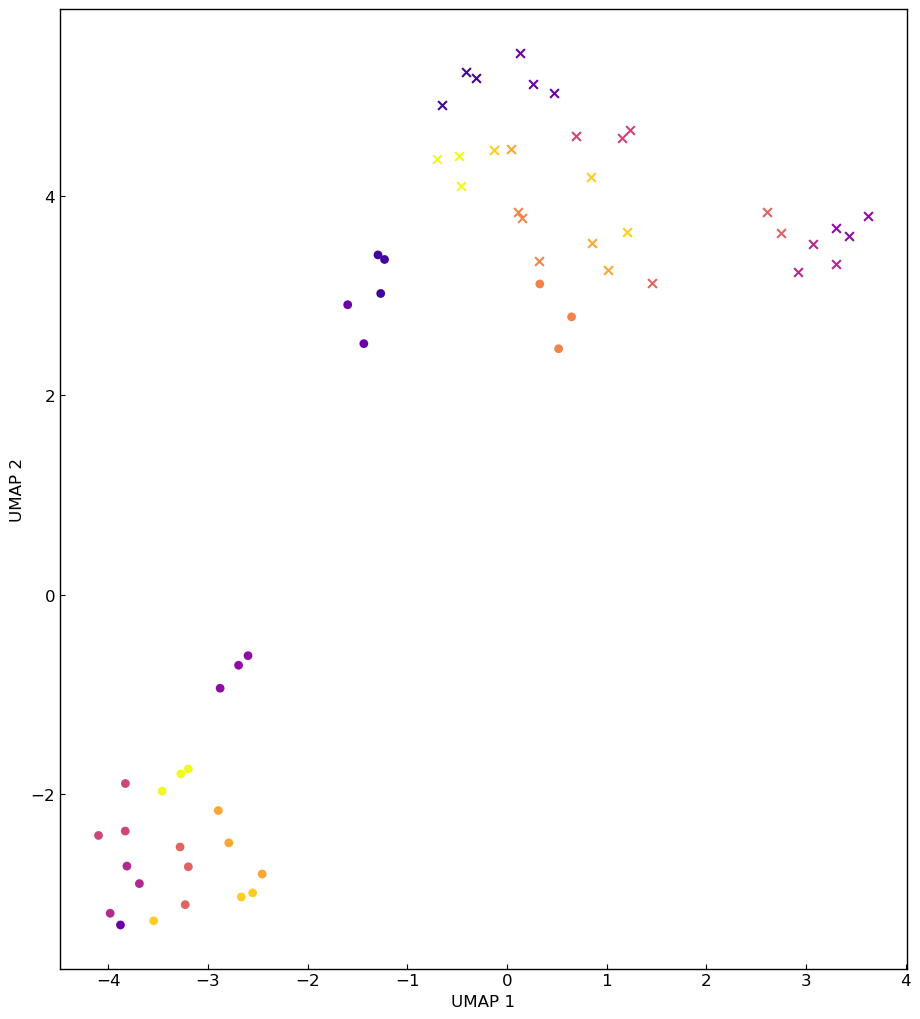

(<Figure size 100x100 with 1 Axes>, <Axes: ylabel='Size Fraction'>)

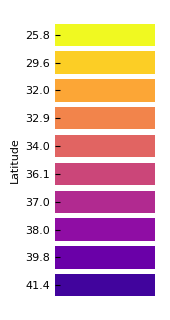

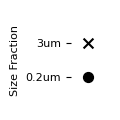

In [497]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40,
    markerstyle=markerstyle
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

marker_legend(
    sizes,
    markers,
    ylabel="Size Fraction",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)

### Compare Lattitudes in G3PA

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(60, 2)


(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='UMAP 1', ylabel='UMAP 2'>)

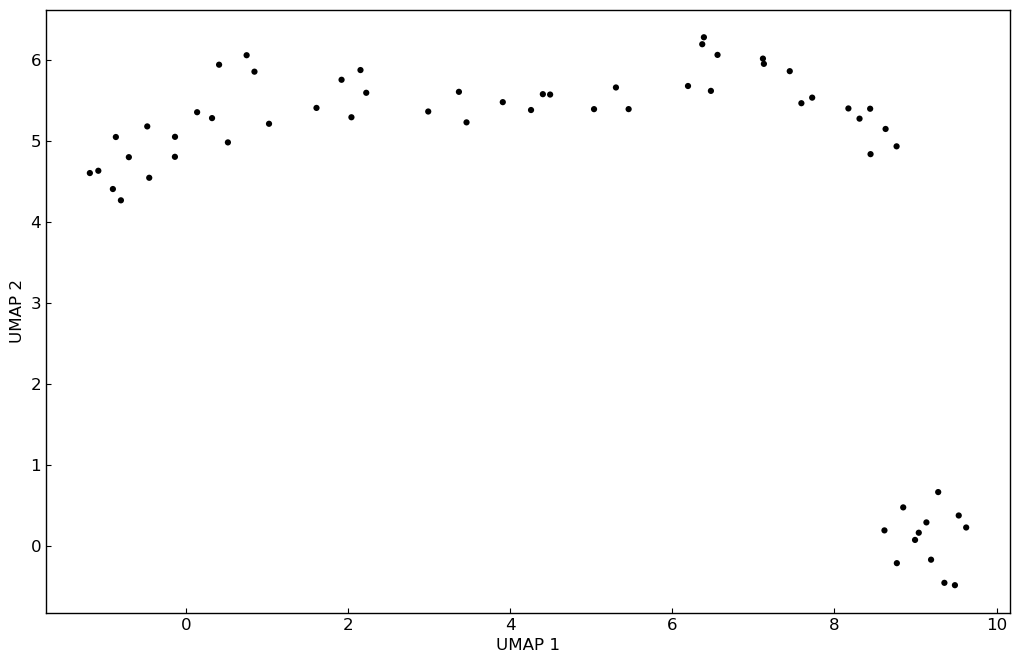

In [498]:
bool_ass = table.assembly == "G3PA"

table_vals_sub = table.iloc[:, 9:][bool_ass].values

embedding = reducer.fit_transform(table_vals_sub)
print(embedding.shape)
plot_umap(embedding=embedding, alpha=1, markersize=20)

Get latitudes

In [499]:
samples = table.loc[bool_ass, 'sample'].values
np.unique(samples)

array(['UW1', 'UW10', 'UW11', 'UW12', 'UW13', 'UW14', 'UW16', 'UW17',
       'UW19', 'UW2', 'UW20', 'UW21', 'UW22', 'UW23', 'UW24', 'UW25',
       'UW26', 'UW27', 'UW28', 'UW29', 'UW30', 'UW31', 'UW32', 'UW33',
       'UW34', 'UW35', 'UW36', 'UW37', 'UW38', 'UW39', 'UW4', 'UW40',
       'UW41', 'UW42', 'UW43', 'UW44', 'UW45', 'UW46', 'UW47', 'UW48',
       'UW49', 'UW5', 'UW50', 'UW51', 'UW52', 'UW53', 'UW54', 'UW55',
       'UW56', 'UW57', 'UW59', 'UW60', 'UW62', 'UW63', 'UW64', 'UW66',
       'UW67', 'UW7', 'UW8', 'UW9'], dtype=object)

Load metadata table

In [500]:
dir_diel = '../repo-armbrust-metat/gradients3/g3_uw_pa_metat'
fn_G3PA_diel_metadata = f'{dir_diel}/sample_metadata.csv'

G3PA_diel_metadata = pd.read_csv(fn_G3PA_diel_metadata)
G3PA_diel_metadata.shape, G3PA_diel_metadata[:3]

((64, 14),
                      SampleID  Cruise  Station  Cast  Filter Replicate  Depth  \
 0  G3.UW.PA.UW25_1.7m.0_2um.A  km1906      NaN   NaN     0.2         A      7   
 1  G3.UW.PA.UW25_1.7m.0_2um.B  km1906      NaN   NaN     0.2         B      7   
 2  G3.UW.PA.UW25_1.7m.0_2um.C  km1906      NaN   NaN     0.2         C      7   
 
        Datetime  Latitude  Longitude  SequencingID  Alias1 Alias2  \
 0  4/11/19 5:45     25.87       -158        442931  UW25 A   UW36   
 1  4/11/19 5:45     25.87       -158        442946  UW25 B   UW51   
 2  4/11/19 5:45     25.87       -158        442922  UW25 C   UW27   
 
                        Notes  
 0                        NaN  
 1                        NaN  
 2  metadata_added_02_08_2024  )

Build sample latitude dict

In [501]:
dict_tp_sample = defaultdict(list)
for i, row in G3PA_diel_metadata.iterrows():
    alias = row.Alias2
    if isinstance(alias, str):
        sample = alias
        dict_tp_sample[row.Latitude].append(sample)
dict_tp_sample

defaultdict(list,
            {25.87: ['UW36', 'UW51', 'UW27', 'UW59', 'UW37', 'UW57'],
             29.46: ['UW44', 'UW21', 'UW67', 'UW29'],
             31.43: ['UW4', 'UW31', 'UW2', 'UW64', 'UW20', 'UW1'],
             32.3: ['UW13', 'UW58', 'UW19', 'UW66', 'UW7', 'UW10'],
             32.93: ['UW61', 'UW26', 'UW56', 'UW8', 'UW9', 'UW35'],
             35.96: ['UW6', 'UW53', 'UW24', 'UW43', 'UW30', 'UW5'],
             35.83: ['UW55', 'UW46', 'UW52', 'UW41', 'UW60', 'UW33'],
             37.0: ['UW17', 'UW34', 'UW54', 'UW32', 'UW25', 'UW47'],
             38.97: ['UW11', 'UW18', 'UW50', 'UW42', 'UW23', 'UW39'],
             40.88: ['UW14', 'UW28', 'UW63', 'UW45', 'UW38', 'UW49'],
             40.09: ['UW12', 'UW40', 'UW48', 'UW62', 'UW22', 'UW16']})

In [502]:
dict_sample_lat = {}
for i, row in G3PA_diel_metadata.iterrows():
    alias = row.Alias2
    if isinstance(alias, str):
        if not np.isnan(row.Latitude):
            sample = alias
            dict_sample_lat[sample] = row.Latitude
dict_sample_lat

{'UW36': 25.87,
 'UW51': 25.87,
 'UW27': 25.87,
 'UW59': 25.87,
 'UW37': 25.87,
 'UW57': 25.87,
 'UW44': 29.46,
 'UW21': 29.46,
 'UW67': 29.46,
 'UW29': 29.46,
 'UW4': 31.43,
 'UW31': 31.43,
 'UW2': 31.43,
 'UW64': 31.43,
 'UW20': 31.43,
 'UW1': 31.43,
 'UW13': 32.3,
 'UW58': 32.3,
 'UW19': 32.3,
 'UW66': 32.3,
 'UW7': 32.3,
 'UW10': 32.3,
 'UW61': 32.93,
 'UW26': 32.93,
 'UW56': 32.93,
 'UW8': 32.93,
 'UW9': 32.93,
 'UW35': 32.93,
 'UW6': 35.96,
 'UW53': 35.96,
 'UW24': 35.96,
 'UW43': 35.96,
 'UW30': 35.96,
 'UW5': 35.96,
 'UW55': 35.83,
 'UW46': 35.83,
 'UW52': 35.83,
 'UW41': 35.83,
 'UW60': 35.83,
 'UW33': 35.83,
 'UW17': 37.0,
 'UW34': 37.0,
 'UW54': 37.0,
 'UW32': 37.0,
 'UW25': 37.0,
 'UW47': 37.0,
 'UW11': 38.97,
 'UW18': 38.97,
 'UW50': 38.97,
 'UW42': 38.97,
 'UW23': 38.97,
 'UW39': 38.97,
 'UW14': 40.88,
 'UW28': 40.88,
 'UW63': 40.88,
 'UW45': 40.88,
 'UW38': 40.88,
 'UW49': 40.88,
 'UW12': 40.09,
 'UW40': 40.09,
 'UW48': 40.09,
 'UW62': 40.09,
 'UW22': 40.09,
 'UW16': 40.

Sort latitudes

In [503]:
datetime_sort = sorted(list(set(dict_sample_lat.values())))
datetime_sort

[25.87, 29.46, 31.43, 32.3, 32.93, 35.83, 35.96, 37.0, 38.97, 40.09, 40.88]

Color umap by latitude

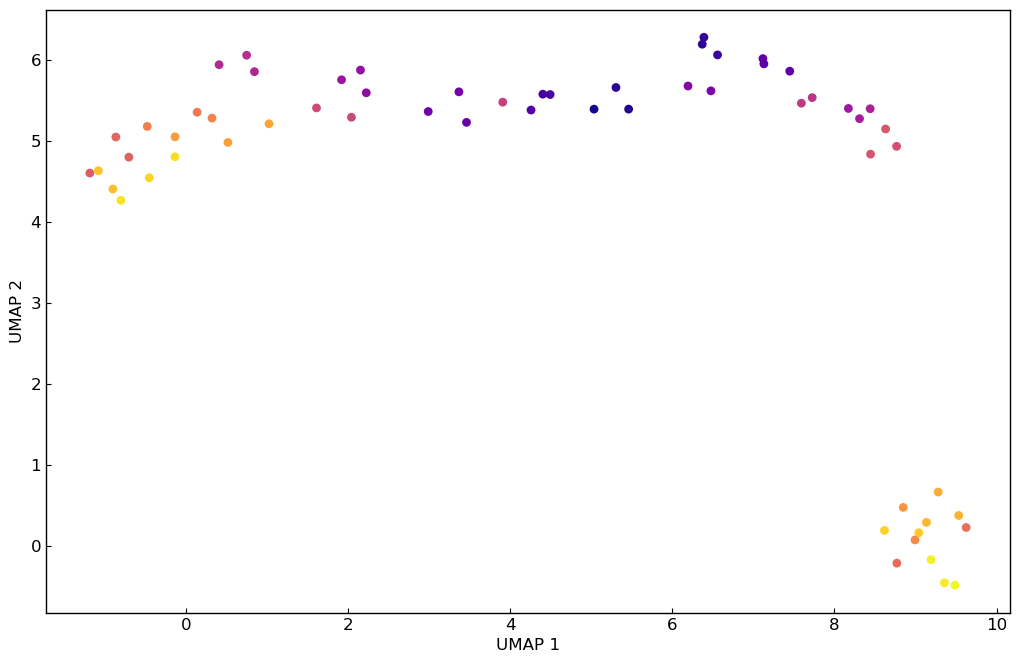

(<Figure size 150x300 with 1 Axes>, <Axes: ylabel='Latitude'>)

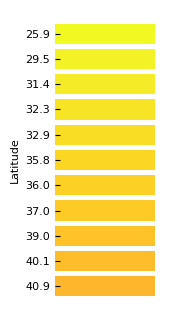

In [504]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [s for tp in datetime_sort for s in dict_tp_sample[tp]]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

#### Separate by size fraction

In [505]:
sizes = table.loc[bool_ass, 'size'].unique()
sizes

array([nan], dtype=object)

In [506]:
markers = ['o','x']
dict_size_marker = dict(zip(sizes, markers))

sizes_all = table.loc[bool_ass, 'size'].values

markerstyle = [dict_size_marker[s] for s in sizes_all]

In [507]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40,
    markerstyle=markerstyle
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

marker_legend(
    sizes,
    markers,
    ylabel="Size Fraction",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)

TypeError: unhashable type: 'list'

### Compare Lattitudes in G3NS

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(53, 2)


(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='UMAP 1', ylabel='UMAP 2'>)

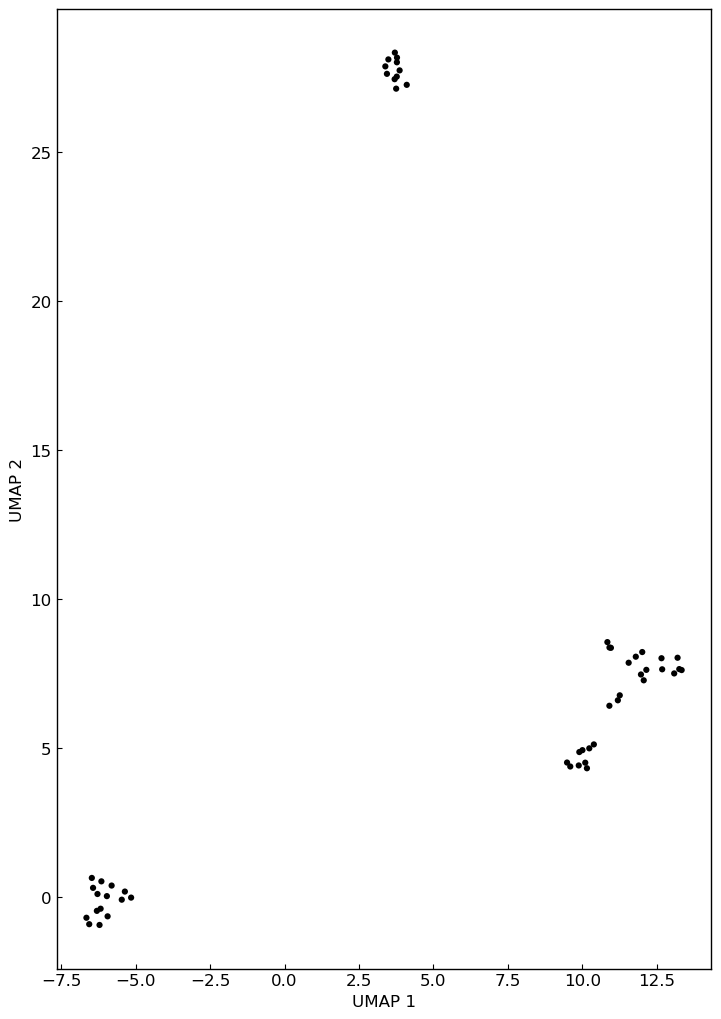

In [508]:
bool_ass = table.assembly == "G3.UW.NS"

table_vals_sub = table.iloc[:, 9:][bool_ass].values

embedding = reducer.fit_transform(table_vals_sub)
print(embedding.shape)
plot_umap(embedding=embedding, alpha=1, markersize=20)

Get latitudes

In [509]:
samples = table.loc[bool_ass, 'sample'].values
np.unique(samples)

array(['UW25', 'UW29', 'UW31', 'UW32', 'UW35', 'UW37', 'UW38', 'UW40'],
      dtype=object)

Load metadata table

In [510]:
dir_diel = '../repo-armbrust-metat/gradients3/g3_uw_ns_metat'
fn_G3PA_diel_metadata = f'{dir_diel}/sample_metadata.csv'

G3PA_diel_metadata = pd.read_csv(fn_G3PA_diel_metadata)
G3PA_diel_metadata.shape, G3PA_diel_metadata[:3]

((53, 14),
                      SampleID  Cruise  Station  Cast  Filter Replicate  Depth  \
 0    G3.UW.NS.UW25_1.7m.3um.A  km1906      NaN   NaN     3.0         A      7   
 1    G3.UW.NS.UW25_1.7m.3um.B  km1906      NaN   NaN     3.0         B      7   
 2  G3.UW.NS.UW25_1.7m.0_2um.A  km1906      NaN   NaN     0.2         A      7   
 
             Datetime  Latitude  Longitude  SequencingID  Alias1 Alias2  Notes  
 0  04/11/19 05:45:00     25.87       -158        719376  UW25 A   UW59    NaN  
 1  04/11/19 05:45:00     25.87       -158        719355  UW25 B   UW37    NaN  
 2  04/11/19 05:45:00     25.87       -158        719354  UW25 A   UW36    NaN  )

Build sample latitude dict

In [511]:
dict_tp_sample = {}
for i, row in G3PA_diel_metadata.iterrows():
    alias = row.Alias1
    if isinstance(alias, str):
        if not np.isnan(row.Latitude):
            sample = alias.split(' ')[0]
            dict_tp_sample[row.Latitude] = sample
dict_tp_sample

{25.87: 'UW25',
 29.46: 'UW29',
 32.3: 'UW32',
 35.96: 'UW35',
 38.97: 'UW38',
 37.0: 'UW37',
 32.93: 'UW32',
 40.88: 'UW40',
 40.09: 'UW40',
 35.83: 'UW35',
 31.43: 'UW31'}

Sort latitudes

In [512]:
datetime_sort = sorted(list(dict_tp_sample.keys()))
datetime_sort

[25.87, 29.46, 31.43, 32.3, 32.93, 35.83, 35.96, 37.0, 38.97, 40.09, 40.88]

Color umap by latitude

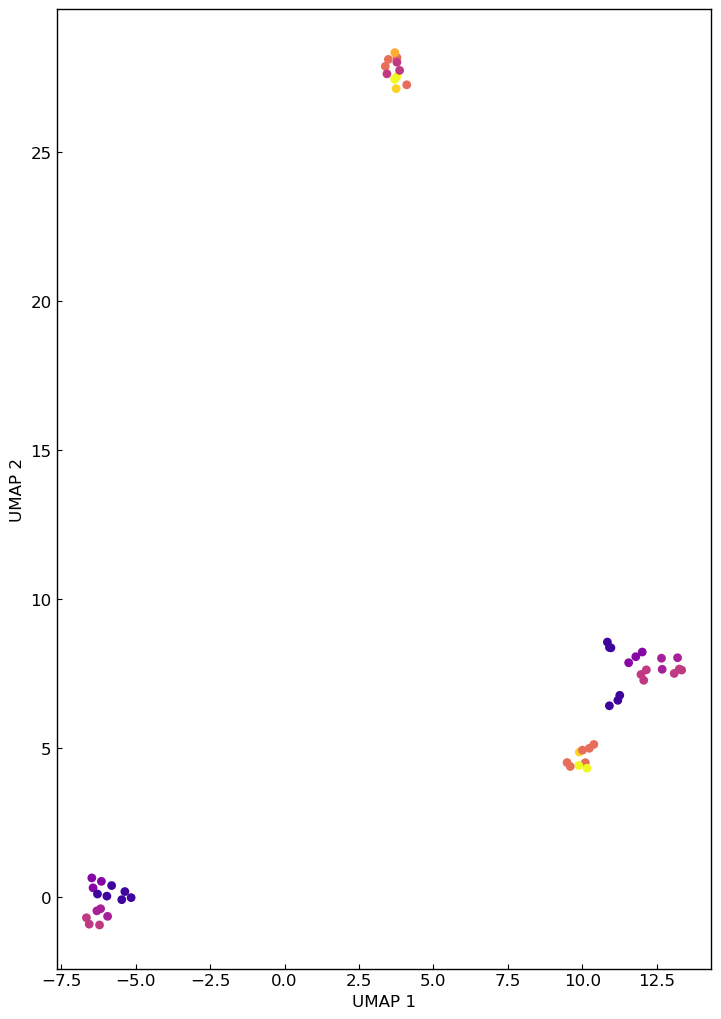

(<Figure size 150x300 with 1 Axes>, <Axes: ylabel='Latitude'>)

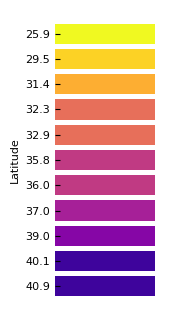

In [513]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

#### Separate by size fraction

In [514]:
sizes = table.loc[bool_ass, 'size'].unique()
sizes

array(['3um', '0.2um'], dtype=object)

In [515]:
markers = ['o','x']
dict_size_marker = dict(zip(sizes, markers))

sizes_all = table.loc[bool_ass, 'size'].values

markerstyle = [dict_size_marker[s] for s in sizes_all]

/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


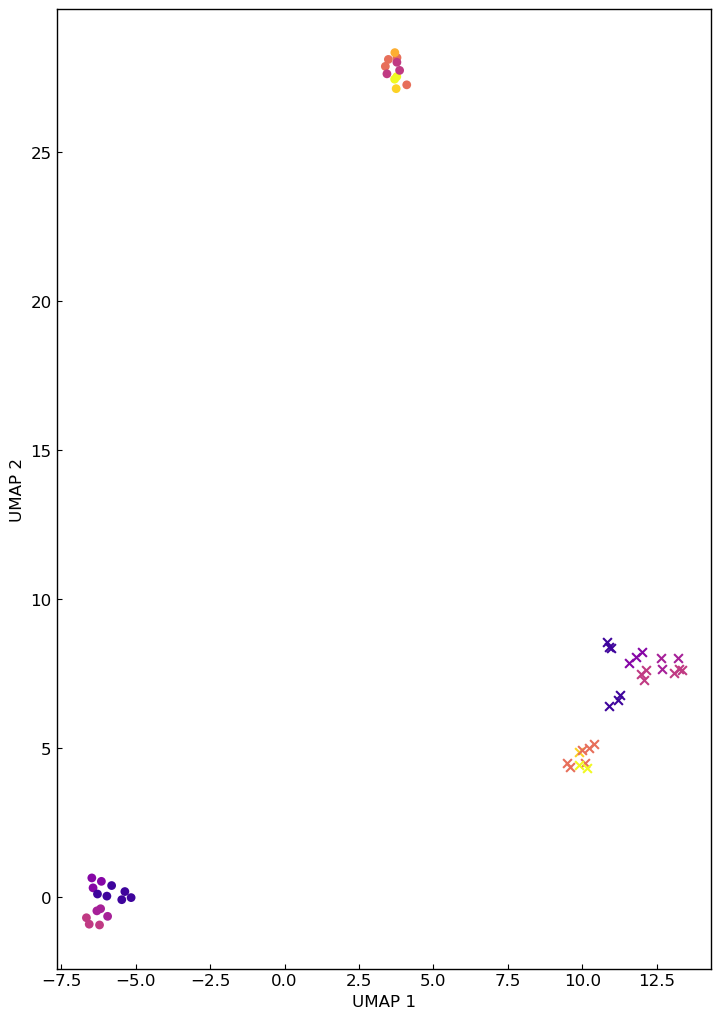

(<Figure size 100x100 with 1 Axes>, <Axes: ylabel='Size Fraction'>)

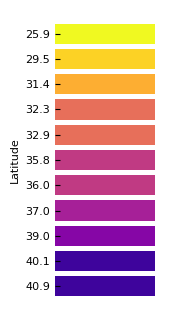

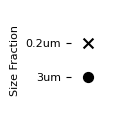

In [516]:
stringlist = table.loc[bool_ass, "sample"].values

samples_sort = [dict_tp_sample[tp] for tp in datetime_sort]

c, dict_time_col = get_colors_from_stringlist(
    stringlist=stringlist, order=samples_sort, cmap_name="plasma_r"
)

plot_umap(
    embedding=embedding, 
    colors=c,
    alpha=1,
    markersize=40,
    markerstyle=markerstyle
)
plt.show()
plt.close()

names = [round(l, 1) for l in datetime_sort]
colors = [dict_time_col[s] for s in samples_sort]
taxon_legend(names, colors, dims=(1.5, 3), ylabel="Latitude", ft=8)

marker_legend(
    sizes,
    markers,
    ylabel="Size Fraction",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)

## Compare Lattitudes in G3PA am vs pm 

### 3um

Get G3PA

In [517]:
bool_ass = (table.assembly == "G3PA")

table_sub = table[bool_ass]
samples = table_sub['sample'].values
np.unique(samples).shape, np.unique(samples)

((60,),
 array(['UW1', 'UW10', 'UW11', 'UW12', 'UW13', 'UW14', 'UW16', 'UW17',
        'UW19', 'UW2', 'UW20', 'UW21', 'UW22', 'UW23', 'UW24', 'UW25',
        'UW26', 'UW27', 'UW28', 'UW29', 'UW30', 'UW31', 'UW32', 'UW33',
        'UW34', 'UW35', 'UW36', 'UW37', 'UW38', 'UW39', 'UW4', 'UW40',
        'UW41', 'UW42', 'UW43', 'UW44', 'UW45', 'UW46', 'UW47', 'UW48',
        'UW49', 'UW5', 'UW50', 'UW51', 'UW52', 'UW53', 'UW54', 'UW55',
        'UW56', 'UW57', 'UW59', 'UW60', 'UW62', 'UW63', 'UW64', 'UW66',
        'UW67', 'UW7', 'UW8', 'UW9'], dtype=object))

Load metadata table

In [518]:
dir_diel = '../repo-armbrust-metat/gradients3/g3_uw_pa_metat'
fn_metadata = f'{dir_diel}/sample_metadata.csv'

metadata = pd.read_csv(fn_metadata)
metadata.shape, metadata[:3]

((64, 14),
                      SampleID  Cruise  Station  Cast  Filter Replicate  Depth  \
 0  G3.UW.PA.UW25_1.7m.0_2um.A  km1906      NaN   NaN     0.2         A      7   
 1  G3.UW.PA.UW25_1.7m.0_2um.B  km1906      NaN   NaN     0.2         B      7   
 2  G3.UW.PA.UW25_1.7m.0_2um.C  km1906      NaN   NaN     0.2         C      7   
 
        Datetime  Latitude  Longitude  SequencingID  Alias1 Alias2  \
 0  4/11/19 5:45     25.87       -158        442931  UW25 A   UW36   
 1  4/11/19 5:45     25.87       -158        442946  UW25 B   UW51   
 2  4/11/19 5:45     25.87       -158        442922  UW25 C   UW27   
 
                        Notes  
 0                        NaN  
 1                        NaN  
 2  metadata_added_02_08_2024  )

Map alias to size and latitude

In [519]:
dict_sample_lat = {}
dict_sample_size = {}
for i, row in metadata.iterrows():
    sample = row.Alias2
    if sample:
        dict_sample_lat[sample] = row.Latitude
        dict_sample_size[sample] = row.Filter

dict_sample_lat, dict_sample_size

({'UW36': 25.87,
  'UW51': 25.87,
  'UW27': 25.87,
  'UW59': 25.87,
  'UW37': 25.87,
  'UW57': 25.87,
  'UW44': 29.46,
  'UW21': 29.46,
  'UW67': 29.46,
  'UW29': 29.46,
  'UW4': 31.43,
  'UW31': 31.43,
  'UW2': 31.43,
  'UW64': 31.43,
  'UW20': 31.43,
  'UW1': 31.43,
  'UW13': 32.3,
  'UW58': 32.3,
  'UW19': 32.3,
  'UW66': 32.3,
  'UW7': 32.3,
  'UW10': 32.3,
  'UW61': 32.93,
  'UW26': 32.93,
  'UW56': 32.93,
  'UW8': 32.93,
  'UW9': 32.93,
  'UW35': 32.93,
  'UW6': 35.96,
  'UW53': 35.96,
  'UW24': 35.96,
  'UW43': 35.96,
  'UW30': 35.96,
  'UW5': 35.96,
  'UW55': 35.83,
  'UW46': 35.83,
  'UW52': 35.83,
  'UW41': 35.83,
  'UW60': 35.83,
  'UW33': 35.83,
  'UW17': 37.0,
  'UW34': 37.0,
  'UW54': 37.0,
  'UW32': 37.0,
  'UW25': 37.0,
  'UW47': 37.0,
  'UW11': 38.97,
  'UW18': 38.97,
  'UW50': 38.97,
  'UW42': 38.97,
  'UW23': 38.97,
  'UW39': 38.97,
  'UW14': 40.88,
  'UW28': 40.88,
  'UW63': 40.88,
  'UW45': 40.88,
  'UW38': 40.88,
  'UW49': 40.88,
  'UW12': 40.09,
  'UW40': 40.09,


Get size 3um

In [520]:
bool_size = [True if dict_sample_size[s] == 3 else False for s in samples]

table_sub_sub1 = table_sub[bool_size]
samples_sub_sub1 = table_sub_sub1['sample'].values

table_sub_sub1.shape, samples_sub_sub1

((32, 404),
 array(['UW1', 'UW10', 'UW16', 'UW20', 'UW22', 'UW23', 'UW25', 'UW29',
        'UW30', 'UW32', 'UW33', 'UW35', 'UW37', 'UW38', 'UW39', 'UW41',
        'UW42', 'UW43', 'UW45', 'UW47', 'UW49', 'UW5', 'UW57', 'UW59',
        'UW60', 'UW62', 'UW64', 'UW66', 'UW67', 'UW7', 'UW8', 'UW9'],
       dtype=object))

Get latitudes

In [521]:
latitudes1 = [dict_sample_lat[s] for s in samples_sub_sub1]
latitudes1

[31.43,
 32.3,
 40.09,
 31.43,
 40.09,
 38.97,
 37.0,
 29.46,
 35.96,
 37.0,
 35.83,
 32.93,
 25.87,
 40.88,
 38.97,
 35.83,
 38.97,
 35.96,
 40.88,
 37.0,
 40.88,
 35.96,
 25.87,
 25.87,
 35.83,
 40.09,
 31.43,
 32.3,
 29.46,
 32.3,
 32.93,
 32.93]

Get G3PA PM

In [522]:
bool_ass = (table.assembly == "G3.UW.PA")

table_sub = table[bool_ass]
samples = table_sub['sample'].values
np.unique(samples).shape, np.unique(samples), table_sub[:5]

((10,),
 array(['UW24', 'UW27', 'UW31', 'UW32', 'UW33', 'UW34', 'UW36', 'UW37',
        'UW38', 'UW42'], dtype=object),
                                                  fn_KO  \
 415  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 416  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 417  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 418  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 419  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 
                                       fn_sample_counts  assembly sample  \
 415  G3.UW.PA.UW24_1.7m_PM.0.2um.AC.unstranded.abun...  G3.UW.PA   UW24   
 416  G3.UW.PA.UW24_1.7m_PM.0.2um.B.unstranded.abund...  G3.UW.PA   UW24   
 417  G3.UW.PA.UW24_1.7m_PM.3um.A.unstranded.abundan...  G3.UW.PA   UW24   
 418  G3.UW.PA.UW24_1.7m_PM.3um.B.unstranded.abundan...  G3.UW.PA   UW24   
 419  G3.UW.PA.UW27_1.7m_PM.0.2um.A.unstranded.abund...  G3.UW.PA   UW27   
 
     ammendment timepoint depth   size rep         K02016  ...    

Filter by size

In [523]:
table_sub_sub2 = table_sub[table_sub['size'] == '3um']
samples_sub_sub2 = table_sub_sub2['sample'].values

table_sub_sub2.shape, samples_sub_sub2

((28, 404),
 array(['UW24', 'UW24', 'UW27', 'UW31', 'UW31', 'UW32', 'UW32', 'UW32',
        'UW33', 'UW33', 'UW33', 'UW34', 'UW34', 'UW34', 'UW36', 'UW36',
        'UW36', 'UW37', 'UW37', 'UW37', 'UW37', 'UW37', 'UW38', 'UW38',
        'UW38', 'UW42', 'UW42', 'UW42'], dtype=object))

Load metadata table

In [524]:
dir_diel = '../repo-armbrust-metat/gradients3/g3_uw_pa_pm_metat'
fn_metadata = f'{dir_diel}/sample_metadata.csv'

metadata = pd.read_csv(fn_metadata)
metadata.shape, metadata[:3]

((57, 14),
                          SampleID  Cruise Station  Cast  Filter Replicate  \
 0  G3.UW.PA.UW24_1.7m_PM.0.2um.AC  km1906      UW   NaN     0.2        AC   
 1     G3.UW.PA.UW24_1.7m_PM.3um.A  km1906      UW   NaN     3.0         A   
 2   G3.UW.PA.UW24_1.7m_PM.0.2um.B  km1906      UW   NaN     0.2         B   
 
    Depth       Datetime  Latitude  Longitude  SequencingID    Alias1  \
 0      7  4/10/19 18:34     24.23       -158       1292008  UW24 A+C   
 1      7  4/10/19 18:34     24.23       -158       1291970    UW24 A   
 2      7  4/10/19 18:34     24.23       -158       1291997    UW24 B   
 
       Alias2 Notes  
 0  UW73+UW82   NaN  
 1       UW79   NaN  
 2      UW130   NaN  )

Map alias to latitude

In [525]:
dict_sample_lat = {}
for i, row in metadata.iterrows():
    sample = row.Alias1.split(' ')[0]
    if sample:
        dict_sample_lat[sample] = row.Latitude

dict_sample_lat

{'UW24': 24.23,
 'UW27': 27.74,
 'UW31': 31.09,
 'UW32': 32.93,
 'UW33': 33.51,
 'UW34': 34.26,
 'UW36': 36.95,
 'UW37': 37.0,
 'UW38': 38.74,
 'UW42': 42.18}

Get latitudes

In [526]:
latitudes2 = [dict_sample_lat[s] for s in samples_sub_sub2]
latitudes2

[24.23,
 24.23,
 27.74,
 31.09,
 31.09,
 32.93,
 32.93,
 32.93,
 33.51,
 33.51,
 33.51,
 34.26,
 34.26,
 34.26,
 36.95,
 36.95,
 36.95,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 38.74,
 38.74,
 38.74,
 42.18,
 42.18,
 42.18]

Get colors

In [527]:
latitudes = latitudes1 + latitudes2

cmap_name = 'plasma_r'
cmap = plt.get_cmap(cmap_name)
mn, mx = np.min(latitudes), np.max(latitudes)
lat_norm = (np.array(latitudes) - mn) / (mx - mn)
colors = [cmap(l) for l in lat_norm]
len(colors)

60

Get time of day as markerstyle

In [528]:
markers = ['o']*len(latitudes1) + ['x']*len(latitudes2)
dict_time_marker = {'AM':'o','PM':'x'}

Get umap

In [531]:
vals1 = table_sub_sub1.iloc[:, 9:].values
vals2 = table_sub_sub2.iloc[:, 9:].values

vals = np.vstack([vals1, vals2])

reducer = umap.UMAP(n_neighbors=11, metric='cosine')
embedding = reducer.fit_transform(vals)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Plot UMAP

In [532]:
gradient = np.linspace(0,1,256)
np.vstack([gradient]*2).shape

(2, 256)

/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


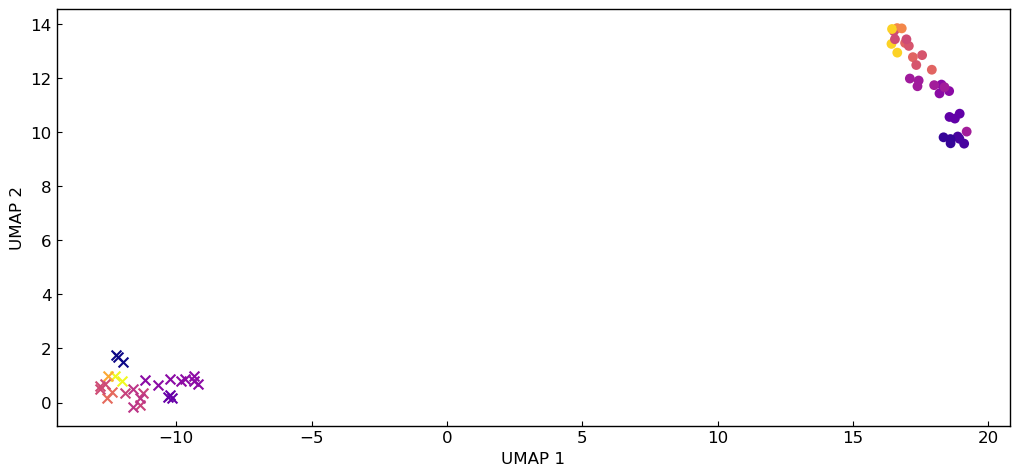

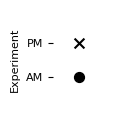

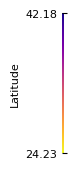

In [533]:
plot_umap(
    embedding,
    markersize=50,
    alpha=1,
    colors=colors,
    markerstyle=markers
)


names_mlegend = list(dict_time_marker.keys())
markers_mlegend = list(dict_time_marker.values())
marker_legend(
    names_mlegend,
    markers_mlegend,
    ylabel="Experiment",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)


horizontal = False
scalevals = latitudes
dims=[1,1.5]
ft=8

gradient = np.linspace(0,1,256)
fig, ax = general_plot(dims=dims, ft=ft)
for i in ax.spines:
    ax.spines[i].set_visible(False)
if horizontal:
    gradient = np.vstack([gradient]*2)
    ax.set_xticks([0,256])
    ax.set_xticklabels([np.min(vals),np.max(vals)])
    ax.set_yticks([])
else:
    gradient = np.hstack([gradient[:,None]]*2)
    ax.set_yticks([0,255])
    ax.set_yticklabels([np.min(scalevals),np.max(scalevals)])
    ax.set_xticks([])
    ax.set_ylabel('Latitude')
                    
ax.imshow(gradient, cmap=cmap_name)
ax.invert_xaxis()
ax.invert_yaxis()




### 0.2um

Get G3PA

In [534]:
bool_ass = (table.assembly == "G3PA")

table_sub = table[bool_ass]
samples = table_sub['sample'].values
np.unique(samples).shape, np.unique(samples)

((60,),
 array(['UW1', 'UW10', 'UW11', 'UW12', 'UW13', 'UW14', 'UW16', 'UW17',
        'UW19', 'UW2', 'UW20', 'UW21', 'UW22', 'UW23', 'UW24', 'UW25',
        'UW26', 'UW27', 'UW28', 'UW29', 'UW30', 'UW31', 'UW32', 'UW33',
        'UW34', 'UW35', 'UW36', 'UW37', 'UW38', 'UW39', 'UW4', 'UW40',
        'UW41', 'UW42', 'UW43', 'UW44', 'UW45', 'UW46', 'UW47', 'UW48',
        'UW49', 'UW5', 'UW50', 'UW51', 'UW52', 'UW53', 'UW54', 'UW55',
        'UW56', 'UW57', 'UW59', 'UW60', 'UW62', 'UW63', 'UW64', 'UW66',
        'UW67', 'UW7', 'UW8', 'UW9'], dtype=object))

Load metadata table

In [535]:
dir_diel = '../repo-armbrust-metat/gradients3/g3_uw_pa_metat'
fn_metadata = f'{dir_diel}/sample_metadata.csv'

metadata = pd.read_csv(fn_metadata)
metadata.shape, metadata[:3]

((64, 14),
                      SampleID  Cruise  Station  Cast  Filter Replicate  Depth  \
 0  G3.UW.PA.UW25_1.7m.0_2um.A  km1906      NaN   NaN     0.2         A      7   
 1  G3.UW.PA.UW25_1.7m.0_2um.B  km1906      NaN   NaN     0.2         B      7   
 2  G3.UW.PA.UW25_1.7m.0_2um.C  km1906      NaN   NaN     0.2         C      7   
 
        Datetime  Latitude  Longitude  SequencingID  Alias1 Alias2  \
 0  4/11/19 5:45     25.87       -158        442931  UW25 A   UW36   
 1  4/11/19 5:45     25.87       -158        442946  UW25 B   UW51   
 2  4/11/19 5:45     25.87       -158        442922  UW25 C   UW27   
 
                        Notes  
 0                        NaN  
 1                        NaN  
 2  metadata_added_02_08_2024  )

Map alias to size and latitude

In [536]:
dict_sample_lat = {}
dict_sample_size = {}
for i, row in metadata.iterrows():
    sample = row.Alias2
    if sample:
        dict_sample_lat[sample] = row.Latitude
        dict_sample_size[sample] = row.Filter

dict_sample_lat, dict_sample_size

({'UW36': 25.87,
  'UW51': 25.87,
  'UW27': 25.87,
  'UW59': 25.87,
  'UW37': 25.87,
  'UW57': 25.87,
  'UW44': 29.46,
  'UW21': 29.46,
  'UW67': 29.46,
  'UW29': 29.46,
  'UW4': 31.43,
  'UW31': 31.43,
  'UW2': 31.43,
  'UW64': 31.43,
  'UW20': 31.43,
  'UW1': 31.43,
  'UW13': 32.3,
  'UW58': 32.3,
  'UW19': 32.3,
  'UW66': 32.3,
  'UW7': 32.3,
  'UW10': 32.3,
  'UW61': 32.93,
  'UW26': 32.93,
  'UW56': 32.93,
  'UW8': 32.93,
  'UW9': 32.93,
  'UW35': 32.93,
  'UW6': 35.96,
  'UW53': 35.96,
  'UW24': 35.96,
  'UW43': 35.96,
  'UW30': 35.96,
  'UW5': 35.96,
  'UW55': 35.83,
  'UW46': 35.83,
  'UW52': 35.83,
  'UW41': 35.83,
  'UW60': 35.83,
  'UW33': 35.83,
  'UW17': 37.0,
  'UW34': 37.0,
  'UW54': 37.0,
  'UW32': 37.0,
  'UW25': 37.0,
  'UW47': 37.0,
  'UW11': 38.97,
  'UW18': 38.97,
  'UW50': 38.97,
  'UW42': 38.97,
  'UW23': 38.97,
  'UW39': 38.97,
  'UW14': 40.88,
  'UW28': 40.88,
  'UW63': 40.88,
  'UW45': 40.88,
  'UW38': 40.88,
  'UW49': 40.88,
  'UW12': 40.09,
  'UW40': 40.09,


Get size 0.2um

In [537]:
bool_size = [True if dict_sample_size[s] == 0.2 else False for s in samples]

table_sub_sub1 = table_sub[bool_size]
samples_sub_sub1 = table_sub_sub1['sample'].values

table_sub_sub1.shape, samples_sub_sub1

((28, 404),
 array(['UW11', 'UW12', 'UW13', 'UW14', 'UW17', 'UW19', 'UW2', 'UW21',
        'UW24', 'UW26', 'UW27', 'UW28', 'UW31', 'UW34', 'UW36', 'UW4',
        'UW40', 'UW44', 'UW46', 'UW48', 'UW50', 'UW51', 'UW52', 'UW53',
        'UW54', 'UW55', 'UW56', 'UW63'], dtype=object))

Get latitudes

In [538]:
latitudes1 = [dict_sample_lat[s] for s in samples_sub_sub1]
latitudes1

[38.97,
 40.09,
 32.3,
 40.88,
 37.0,
 32.3,
 31.43,
 29.46,
 35.96,
 32.93,
 25.87,
 40.88,
 31.43,
 37.0,
 25.87,
 31.43,
 40.09,
 29.46,
 35.83,
 40.09,
 38.97,
 25.87,
 35.83,
 35.96,
 37.0,
 35.83,
 32.93,
 40.88]

Get G3PA PM

In [539]:
bool_ass = (table.assembly == "G3.UW.PA")

table_sub = table[bool_ass]
samples = table_sub['sample'].values
np.unique(samples).shape, np.unique(samples), table_sub[:5]

((10,),
 array(['UW24', 'UW27', 'UW31', 'UW32', 'UW33', 'UW34', 'UW36', 'UW37',
        'UW38', 'UW42'], dtype=object),
                                                  fn_KO  \
 415  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 416  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 417  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 418  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 419  NPac.G3PA_PM.bf100.id99.aa.best.kofam.incT30.c...   
 
                                       fn_sample_counts  assembly sample  \
 415  G3.UW.PA.UW24_1.7m_PM.0.2um.AC.unstranded.abun...  G3.UW.PA   UW24   
 416  G3.UW.PA.UW24_1.7m_PM.0.2um.B.unstranded.abund...  G3.UW.PA   UW24   
 417  G3.UW.PA.UW24_1.7m_PM.3um.A.unstranded.abundan...  G3.UW.PA   UW24   
 418  G3.UW.PA.UW24_1.7m_PM.3um.B.unstranded.abundan...  G3.UW.PA   UW24   
 419  G3.UW.PA.UW27_1.7m_PM.0.2um.A.unstranded.abund...  G3.UW.PA   UW27   
 
     ammendment timepoint depth   size rep         K02016  ...    

Filter by size

In [540]:
table_sub_sub2 = table_sub[table_sub['size'] == '0.2um']
samples_sub_sub2 = table_sub_sub2['sample'].values

table_sub_sub2.shape, samples_sub_sub2

((29, 404),
 array(['UW24', 'UW24', 'UW27', 'UW27', 'UW31', 'UW31', 'UW32', 'UW32',
        'UW32', 'UW33', 'UW33', 'UW33', 'UW34', 'UW34', 'UW34', 'UW36',
        'UW36', 'UW36', 'UW37', 'UW37', 'UW37', 'UW37', 'UW37', 'UW38',
        'UW38', 'UW38', 'UW42', 'UW42', 'UW42'], dtype=object))

Load metadata table

In [541]:
dir_diel = '../repo-armbrust-metat/gradients3/g3_uw_pa_pm_metat'
fn_metadata = f'{dir_diel}/sample_metadata.csv'

metadata = pd.read_csv(fn_metadata)
metadata.shape, metadata[:3]

((57, 14),
                          SampleID  Cruise Station  Cast  Filter Replicate  \
 0  G3.UW.PA.UW24_1.7m_PM.0.2um.AC  km1906      UW   NaN     0.2        AC   
 1     G3.UW.PA.UW24_1.7m_PM.3um.A  km1906      UW   NaN     3.0         A   
 2   G3.UW.PA.UW24_1.7m_PM.0.2um.B  km1906      UW   NaN     0.2         B   
 
    Depth       Datetime  Latitude  Longitude  SequencingID    Alias1  \
 0      7  4/10/19 18:34     24.23       -158       1292008  UW24 A+C   
 1      7  4/10/19 18:34     24.23       -158       1291970    UW24 A   
 2      7  4/10/19 18:34     24.23       -158       1291997    UW24 B   
 
       Alias2 Notes  
 0  UW73+UW82   NaN  
 1       UW79   NaN  
 2      UW130   NaN  )

Map alias to latitude

In [542]:
dict_sample_lat = {}
for i, row in metadata.iterrows():
    sample = row.Alias1.split(' ')[0]
    if sample:
        dict_sample_lat[sample] = row.Latitude

dict_sample_lat

{'UW24': 24.23,
 'UW27': 27.74,
 'UW31': 31.09,
 'UW32': 32.93,
 'UW33': 33.51,
 'UW34': 34.26,
 'UW36': 36.95,
 'UW37': 37.0,
 'UW38': 38.74,
 'UW42': 42.18}

Get latitudes

In [543]:
latitudes2 = [dict_sample_lat[s] for s in samples_sub_sub2]
latitudes2

[24.23,
 24.23,
 27.74,
 27.74,
 31.09,
 31.09,
 32.93,
 32.93,
 32.93,
 33.51,
 33.51,
 33.51,
 34.26,
 34.26,
 34.26,
 36.95,
 36.95,
 36.95,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 38.74,
 38.74,
 38.74,
 42.18,
 42.18,
 42.18]

Get colors

In [544]:
latitudes = latitudes1 + latitudes2

cmap_name = 'plasma_r'
cmap = plt.get_cmap(cmap_name)
mn, mx = np.min(latitudes), np.max(latitudes)
lat_norm = (np.array(latitudes) - mn) / (mx - mn)
colors = [cmap(l) for l in lat_norm]
len(colors)

57

Get time of day as markerstyle

In [545]:
markers = ['o']*len(latitudes1) + ['x']*len(latitudes2)
dict_time_marker = {'AM':'o','PM':'x'}

Get umap

In [546]:
vals1 = table_sub_sub1.iloc[:, 9:].values
vals2 = table_sub_sub2.iloc[:, 9:].values

vals = np.vstack([vals1, vals2])

reducer = umap.UMAP(n_neighbors=11, metric='cosine')
embedding = reducer.fit_transform(vals)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Plot UMAP

/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


(<Figure size 100x100 with 1 Axes>, <Axes: ylabel='Experiment'>)

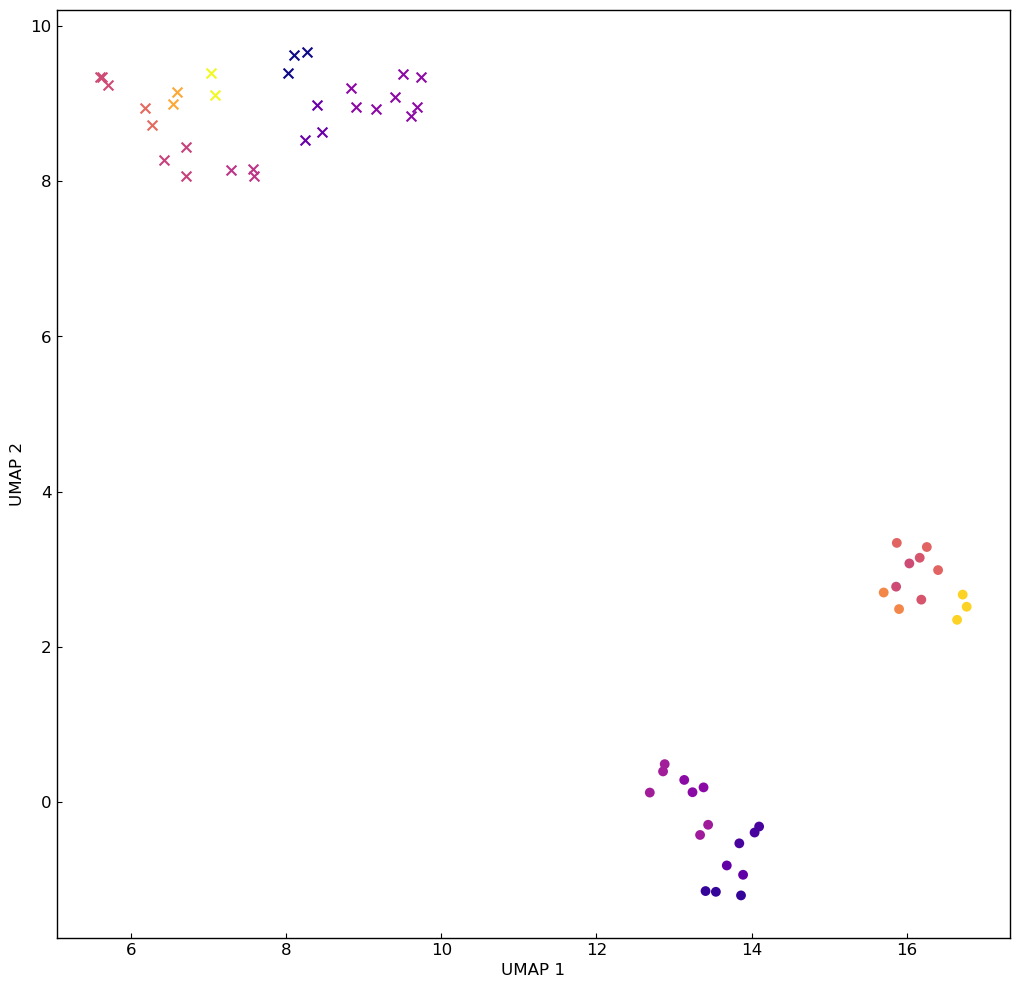

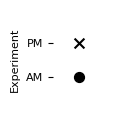

In [547]:
plot_umap(
    embedding,
    markersize=50,
    alpha=1,
    colors=colors,
    markerstyle=markers
)


names_mlegend = list(dict_time_marker.keys())
markers_mlegend = list(dict_time_marker.values())
marker_legend(
    names_mlegend,
    markers_mlegend,
    ylabel="Experiment",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)

## G5

In [548]:
bool_ass = table.assembly == "G5"

table_sub = table[bool_ass]
samples_sub = table_sub['sample']
samples_sub

472    Mix2
473    Mix1
474    Mix1
475    Mix2
476    Mix1
477    Mix1
478    Mix2
479    Mix1
480    Mix1
481    Mix2
482    Mix1
483    Mix2
484    Mix2
485    Mix1
486    Mix1
487    Mix2
488    Mix2
489    Mix2
490    Mix1
491    Mix2
492    Mix1
493    Mix2
494    Mix1
495    Mix1
496    Mix2
497    Mix2
498    Mix2
499    Mix1
500    Mix1
501    Mix2
502     RR2
503     RR1
504     RR1
505     RR2
506     RR2
507     RR1
508     RR2
509     RR2
510     RR1
511     RR2
512     RR1
513     RR2
514     RR1
515     RR2
516     RR2
517     RR2
518     RR2
519     RR2
520     RR1
521     RR1
522     RR1
523     RR1
524     RR2
525     RR2
526     RR1
527     RR1
528     RR1
529     RR2
530     RR1
Name: sample, dtype: object

Get mix and RR

In [549]:
bool_mix = (table_sub['sample'] == 'Mix1') | (table_sub['sample'] == 'Mix2')
bool_RR = (table_sub['sample'] == 'RR1') | (table_sub['sample'] == 'RR2')

table_RR = table_sub[bool_RR]
table_mix = table_sub[bool_mix]

table_RR.shape, table_mix.shape


((29, 404), (30, 404))

### RR

Get ammendments as color

In [550]:
ammendments = table_RR['ammendment'].values
colors, dict_amm_col = get_colors_from_stringlist(ammendments, order="", cmap_name="tab10")


Get RR location as marker

In [551]:
rr_loc = table_RR['sample'].values
dict_rr_mark = {'RR1':'o','RR2':'x'}
markers = [dict_rr_mark[r] for r in rr_loc]

Get Umap

In [554]:
vals = table_RR.iloc[:, 9:].values

reducer = umap.UMAP(n_neighbors=11)
embedding = reducer.fit_transform(vals)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Plot UMAP

/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


(<Figure size 100x100 with 1 Axes>, <Axes: ylabel='Experiment'>)

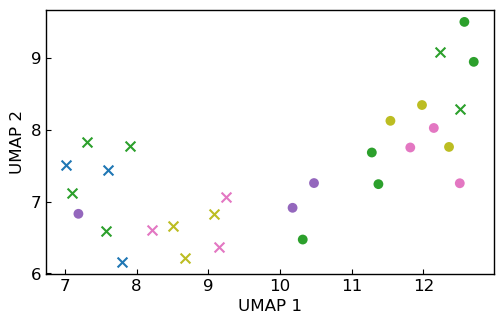

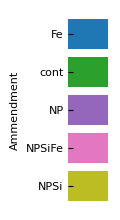

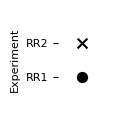

In [555]:
plot_umap(
    embedding,
    figsize=(5,5),
    markersize=50,
    alpha=1,
    colors=colors,
    markerstyle=markers
)


names_legend = list(dict_amm_col.keys())
colors_legend = list(dict_amm_col.values())
taxon_legend(names_legend, colors_legend, dims=(1, 2), ylabel="Ammendment", ft=8)

names_mlegend = list(dict_rr_mark.keys())
markers_mlegend = list(dict_rr_mark.values())
marker_legend(
    names_mlegend,
    markers_mlegend,
    ylabel="Experiment",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)

### Mix

Get ammendments as color

In [556]:
ammendments = table_mix['ammendment'].values
colors, dict_amm_col = get_colors_from_stringlist(ammendments, order="", cmap_name="tab10")


Get RR location as marker

In [557]:
rr_loc = table_mix['sample'].values
dict_rr_mark = {'Mix1':'o','Mix2':'x'}
markers = [dict_rr_mark[r] for r in rr_loc]

Get Umap

In [560]:
vals = table_mix.iloc[:, 9:].values

reducer = umap.UMAP(n_neighbors=11)
embedding = reducer.fit_transform(vals)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Plot UMAP

/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_1074274/4272187251.py:50: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


(<Figure size 100x100 with 1 Axes>, <Axes: ylabel='Experiment'>)

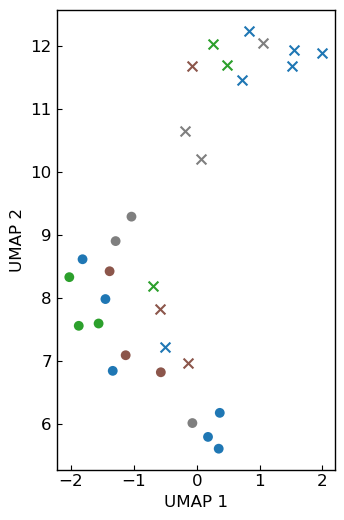

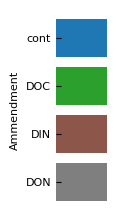

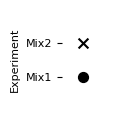

In [561]:
plot_umap(
    embedding,
    figsize=(5,5),
    markersize=50,
    alpha=1,
    colors=colors,
    markerstyle=markers
)


names_legend = list(dict_amm_col.keys())
colors_legend = list(dict_amm_col.values())
taxon_legend(names_legend, colors_legend, dims=(1, 2), ylabel="Ammendment", ft=8)

names_mlegend = list(dict_rr_mark.keys())
markers_mlegend = list(dict_rr_mark.values())
marker_legend(
    names_mlegend,
    markers_mlegend,
    ylabel="Experiment",
    dims=(1, 1),
    ft=8,
    markersize=50,
    text_shift_hv=(1, 0),
)